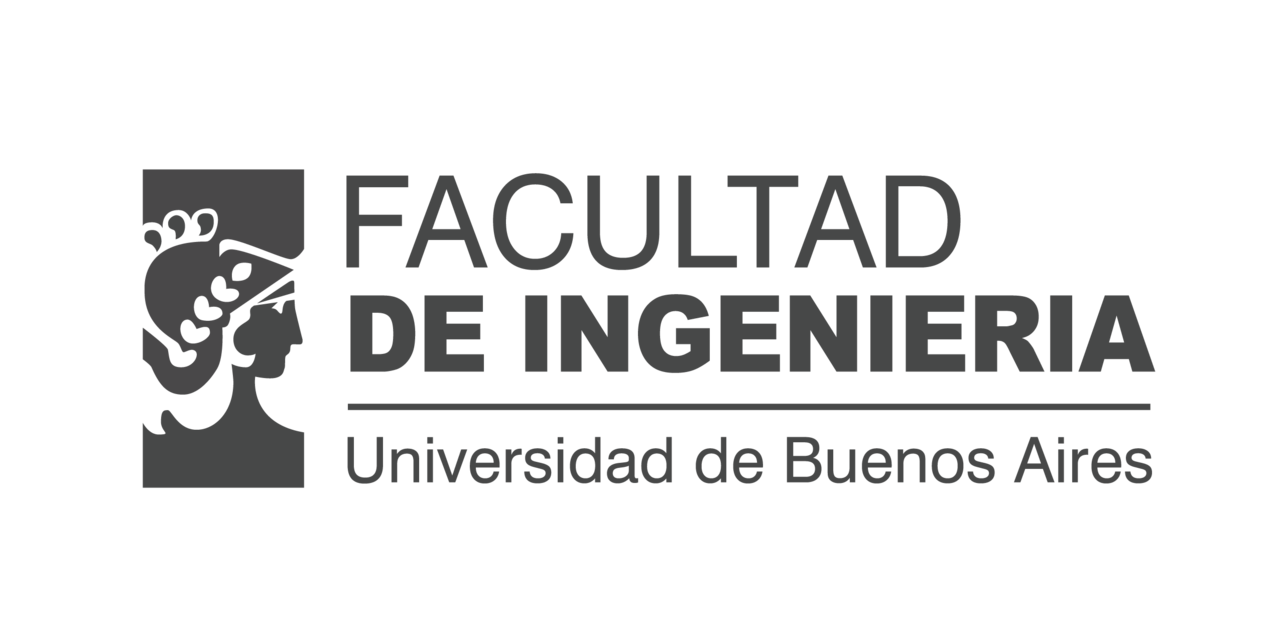

**Profesores:** <br />
Dr. Facundo Adrián Lucianna - facundolucianna@gmail.com <br />
Dr. Álvaro Gabriel Pizá - piza.ag@gmail.com <br />

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/AMIA-TP3 <br />


# Tabla de Contenido

1. [Carga de datasets](#carga-de-datasets)
2. [Regresión Logística para clasificación de reviews de TripAdvisor](#regresión-logística-para-clasificación-de-reviews-de-tripadvisor---inferencia-y-comparaciones-de-modelos)
3. [SVM y CatBoost para clasificación de reviews de TripAdvisor](#svm-y-catboost-para-clasificación-de-reviews-de-tripadvisor---inferencia-y-comparaciones-de-modelos)
    1. [Definiciones](#definiciones)
    2. [Datos para 5 clases](#datos-para-5-clases)
        1. [Instanciación de modelos con los mejores parámetros encontrados y evalucación para 5 clases](#instanciación-de-modelos-con-los-mejores-parámetros-encontrados-y-evalucación-para-5-clases)
            1. [LinearSVC (liblinear) para 5 clases](#linearsvc-liblinear-para-5-clases)
            2. [SVC kernel linear (LibSVM) para 5 clases](#svc-kernel-linear-libsvm-para-5-clases)
            3. [SVC kernel rbf (LibSVM) para 5 clases](#svc-kernel-rbf-libsvm-para-5-clases)
            4. [Catboost para 5 clases (GPU)](#catboost-para-5-clases-gpu)
        2. [Ensemble](#ensemble)
            1. [Hard voting classifier](#hard-voting-classifier)
            2. [Soft voting classifier](#soft-voting-classifier)
        3. [Comparación de modelos](#comparación-de-modelos)
    3. [Datos para 3 clases](#datos-para-3-clases)
        1. [Instanciación de modelos con los mejores parámetros encontrados y evalucación para 3 clases](#instanciación-de-modelos-con-los-mejores-parámetros-encontrados-y-evalucación-para-3-clases)
            1. [LinearSVC (liblinear) para 3 clases](#linearsvc-liblinear-para-3-clases)
            2. [SVC kernel linear (LibSVM) para 3 clases](#svc-kernel-linear-libsvm-para-3-clases)
            3. [SVC kernel rbf (LibSVM) para 3 clases](#svc-kernel-rbf-libsvm-para-3-clases)
            4. [Catboost para 3 clases (GPU)](#catboost-para-3-clases-gpu)
        2. [Ensemble](#ensemble-1)
            1. [Hard voting classifier](#hard-voting-classifier-1)
            2. [Soft voting classifier](#soft-voting-classifier-1)
    4. [Comparación de modelos](#comparación-de-modelos-1)

# Carga de datasets

In [1]:
# Se importan funciones auxiliares para entrenamiento, evaluación y visualización de resultados
from lib.utils import *

In [2]:
df = pd.read_csv("data/cleaned_dataset_processed_balanced.csv", encoding='utf-8')
X = df['cleaned_review']
y = df['rating']
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)


In [3]:
df = pd.read_csv("data/cleaned_dataset_processed_balanced.csv", encoding='utf-8')
X = df['cleaned_review']
y = df['three_classes']
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)


# Regresión Logística para clasificación de reviews de TripAdvisor

Para un problema de análisis de sentimiento con 5 clases (ratings del 1 al 5), la regresión logística multiclase podría ser una buena opción por los siguientes motivos:

1. **Naturaleza del problema**: La regresión logística multiclase es especialmente adecuada para problemas de clasificación donde:
   - Las clases son mutuamente excluyentes (una review solo puede tener un rating)

2. **Interpretabilidad**: A diferencia de modelos más complejos como redes neuronales, la regresión logística:
   - Permite entender qué palabras o características tienen mayor peso en la clasificación
   - Facilita la explicabilidad del modelo al equipo de negocio
   - Provee probabilidades interpretables para cada clase

3. **Eficiencia computacional**:
   - Es más rápida de entrenar que modelos más complejos
   - Requiere menos datos para obtener buenos resultados
   - Es menos propensa al sobreajuste

4. **Buen baseline**: 
   - Sirve como punto de referencia sólido para comparar con modelos más sofisticados
   - Permite establecer un rendimiento mínimo esperado
   - Ayuda a determinar si vale la pena la complejidad adicional de otros modelos

Entendemos que es una elección sólida para este problema de análisis de sentimiento porque permite modelar la naturaleza ordinal de las calificaciones (1-5 estrellas) de manera interpretable y computacionalmente eficiente. Su capacidad para manejar múltiples clases mientras mantiene la simplicidad del modelo la hace ideal como **baseline**, permitiendo entender qué características del texto son más relevantes para la clasificación. Entendemos que, teniendo esta base de performance, modelos mas complejos deberían tener la capacidad de absorber otros patrones y, en consecuencia, mostrar una mejor performance.

## Requerimientos

In [4]:
# Dependencias
from IPython.display import display, Markdown
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

image_path = "diagrams/training_grid_pipeline.png"
base64_string = encode_image_to_base64(image_path)

# Create the Markdown string with the base64 image
markdown_string = f'![Text_Pipeline](data:image/png;base64,{base64_string})'

## Pipeline


1. Transformación de labels (1-5 a 0-4 | 1-3 a 0-2 )
2. Se preparan 4 variantes principales con TfidfVectorizer y LogisticRegression:
   - Basic pipeline
   - Con scaling
   - Con PCA (TruncatedSVD)
   - Con PCA y scaling
3. Se utiliza GridSearchCV para cada pipeline
4. Se registran metricas de entrenamiento y performance

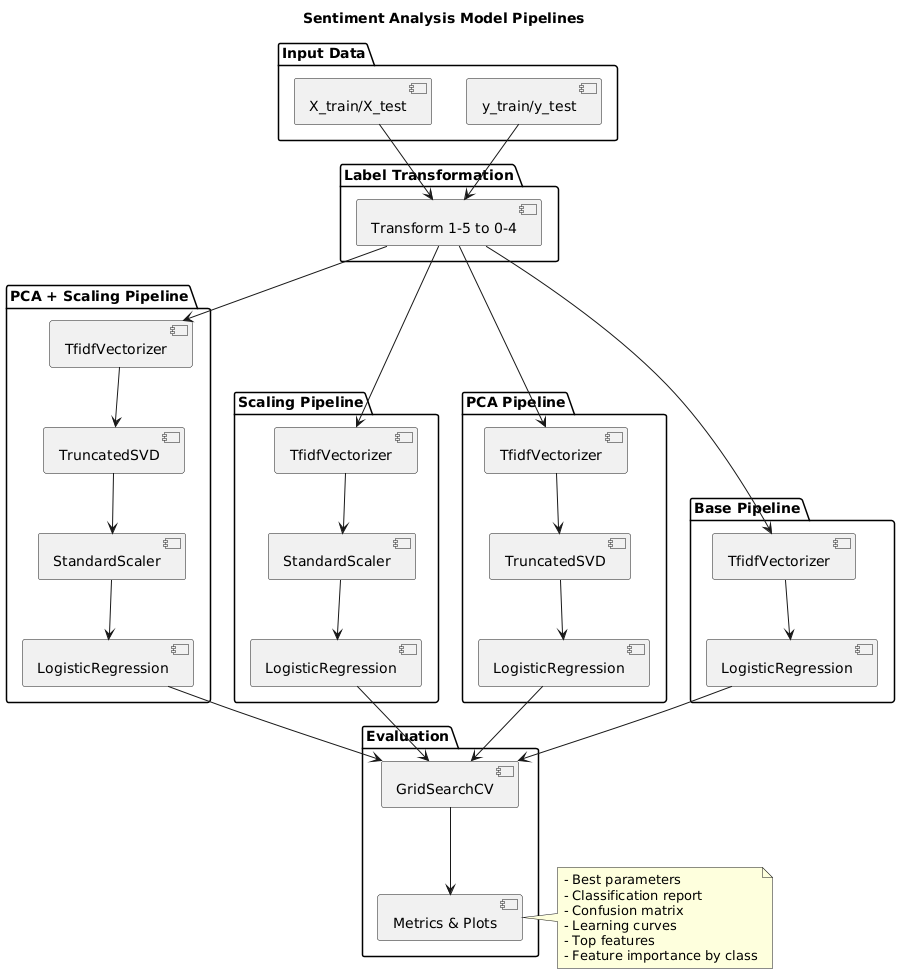

In [5]:
# Display the Markdown
display(Markdown(markdown_string))

## Carga de datos

In [ ]:
dataset = pd.read_csv('data/cleaned_dataset_processed_balanced.csv').sample(n=20508, random_state=42) # 20508
print(dataset.head(5))
print(dataset.shape)

X = dataset['cleaned_review']
y = dataset['rating']
y_three = dataset['three_classes']

X_train, X_test, y_train, y_test = split_data_stratified(X, y)

X_train_three, X_test_three, y_train_three, y_test_three = split_data_stratified(X, y_three)

                                                  review  rating  \
11368  great hotel just returned hotel stayed 24.08 3...       4   
2605   not worth price stayed whirlpool suite 269 nig...       3   
4518   great location clean rooms reviewers hotel gre...       4   
10638  service service, arrived renaissance friday ex...       2   
1962   Title: A Comfortable yet Imperfect Overnight D...       2   

       three_classes                                     cleaned_review  
11368              2  great returned originally petite double tight ...  
2605               1  not worth price whirlpool suite nice worth pri...  
4518               2  great location clean reviewers great bargain l...  
10638              0  service service arrived renaissance friday exp...  
1962               0  title comfortable yet imperfect overnight rece...  
(1000, 4)
Class distribution in splits:

Training set:
rating
1    101
2    136
3     97
4    188
5    278
Name: count, dtype: int64

Test set:
rat

## Entrenamiento y busqueda de parámetros

In [ ]:
def create_param_grids():
    """Define parameter grids for each model"""
    param_grids = {
        'Logistic Regression': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000], # [1000, 3000, 8000, 10000, 15000]
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'With Scaling': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'scaler__with_mean': [False],  # Correct way to parameterize scaler
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'With PCA': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'dim_reduction__n_components': [50, 100, 200],
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'PCA + Scaling': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'dim_reduction__n_components': [50, 100, 200],
            'scaler__with_mean': [False],  # Correct way to parameterize scaler
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },

    }
    return param_grids

### Cinco Clases


Training Logistic Regression with Grid Search...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Logistic Regression Results:
Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.604
Training accuracy: 0.921
Testing accuracy: 0.560
Fit time: 0.302 seconds

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.80      0.74        25
           2       0.69      0.53      0.60        34
           3       0.28      0.38      0.32        24
           4       0.40      0.38      0.39        47
           5       0.69      0.67      0.68        70

    accuracy                           0.56       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.57      0.56      0.56       200



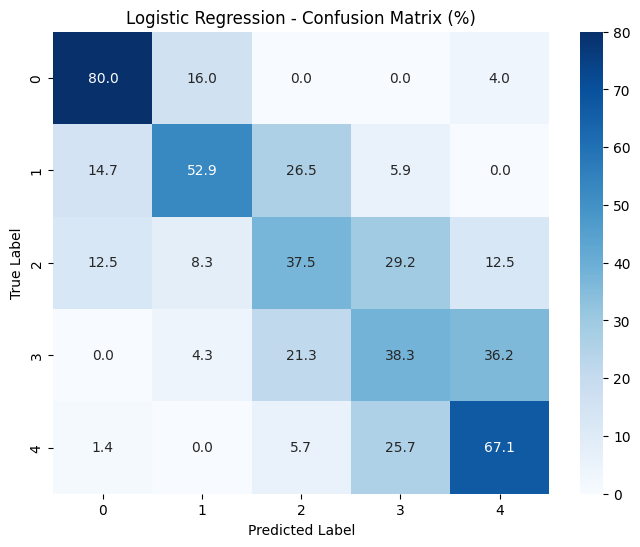

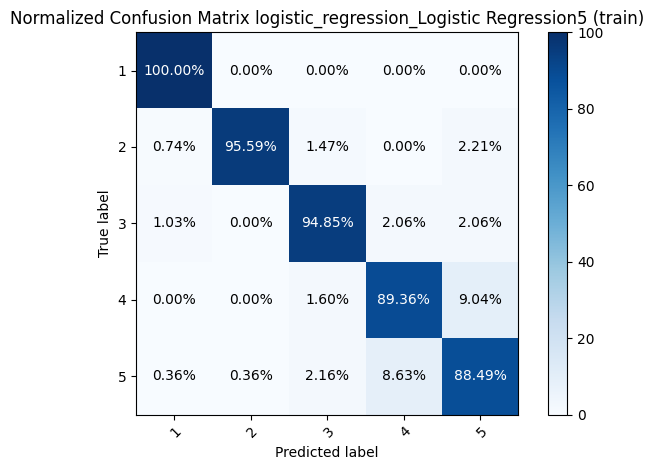

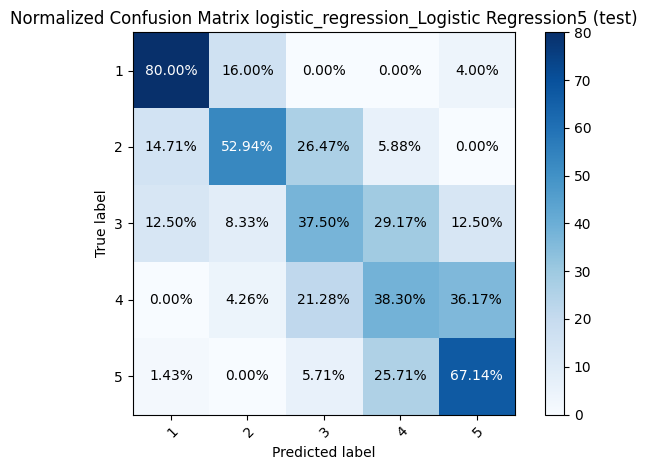

'Y Test'

(array([1, 2, 3, 4, 5]), array([25, 34, 24, 47, 70]))

'Y Test Predictions'

(array([1, 2, 3, 4, 5]), array([29, 26, 32, 45, 68]))

Score for logistic_regression_Logistic Regression5


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             1   0.689655  0.800000  0.740741     25.0       NaN         NaN   
1             2   0.692308  0.529412  0.600000     34.0       NaN         NaN   
2             3   0.281250  0.375000  0.321429     24.0       NaN         NaN   
3             4   0.400000  0.382979  0.391304     47.0       NaN         NaN   
4             5   0.691176  0.671429  0.681159     70.0       NaN         NaN   
5      accuracy        NaN       NaN       NaN      NaN      0.56         NaN   
6     macro avg   0.550878  0.551764  0.546927    200.0       NaN         NaN   
7  weighted avg   0.573561  0.560000  0.563526    200.0       NaN         NaN   
8    time_train        NaN       NaN       NaN      NaN       NaN    0.302464   

                                    Modelo  
0  logistic_regression_Logistic Regression  
1  logistic_regression_Logistic Regression  
2  logistic_regression_Logistic Regression  
3  logistic_regression_Logistic Regression  
4  logistic_regression_Logistic Regression  
5  logistic_regression_Logistic Regression  
6  logistic_regression_Logistic Regression  
7  logistic_regression_Logistic Regression  
8  logistic_regression_Logistic Regression

/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


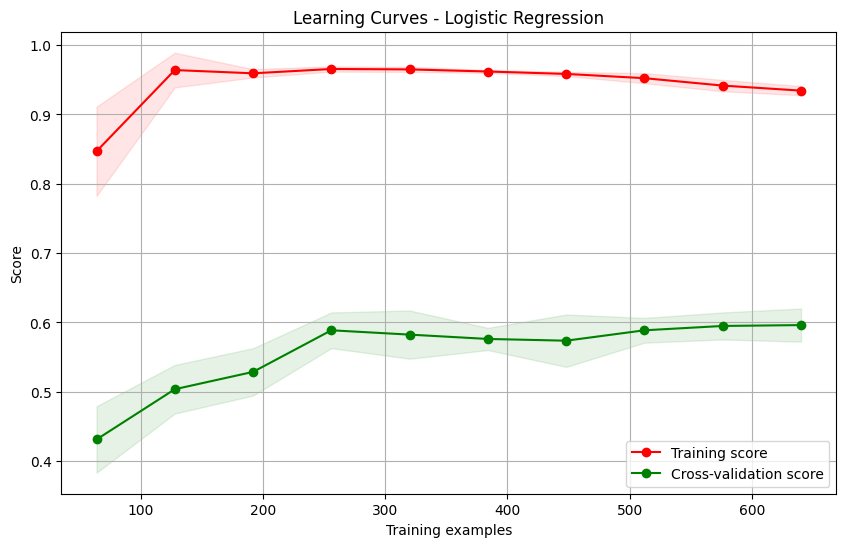


Grid Search Results for Logistic Regression:


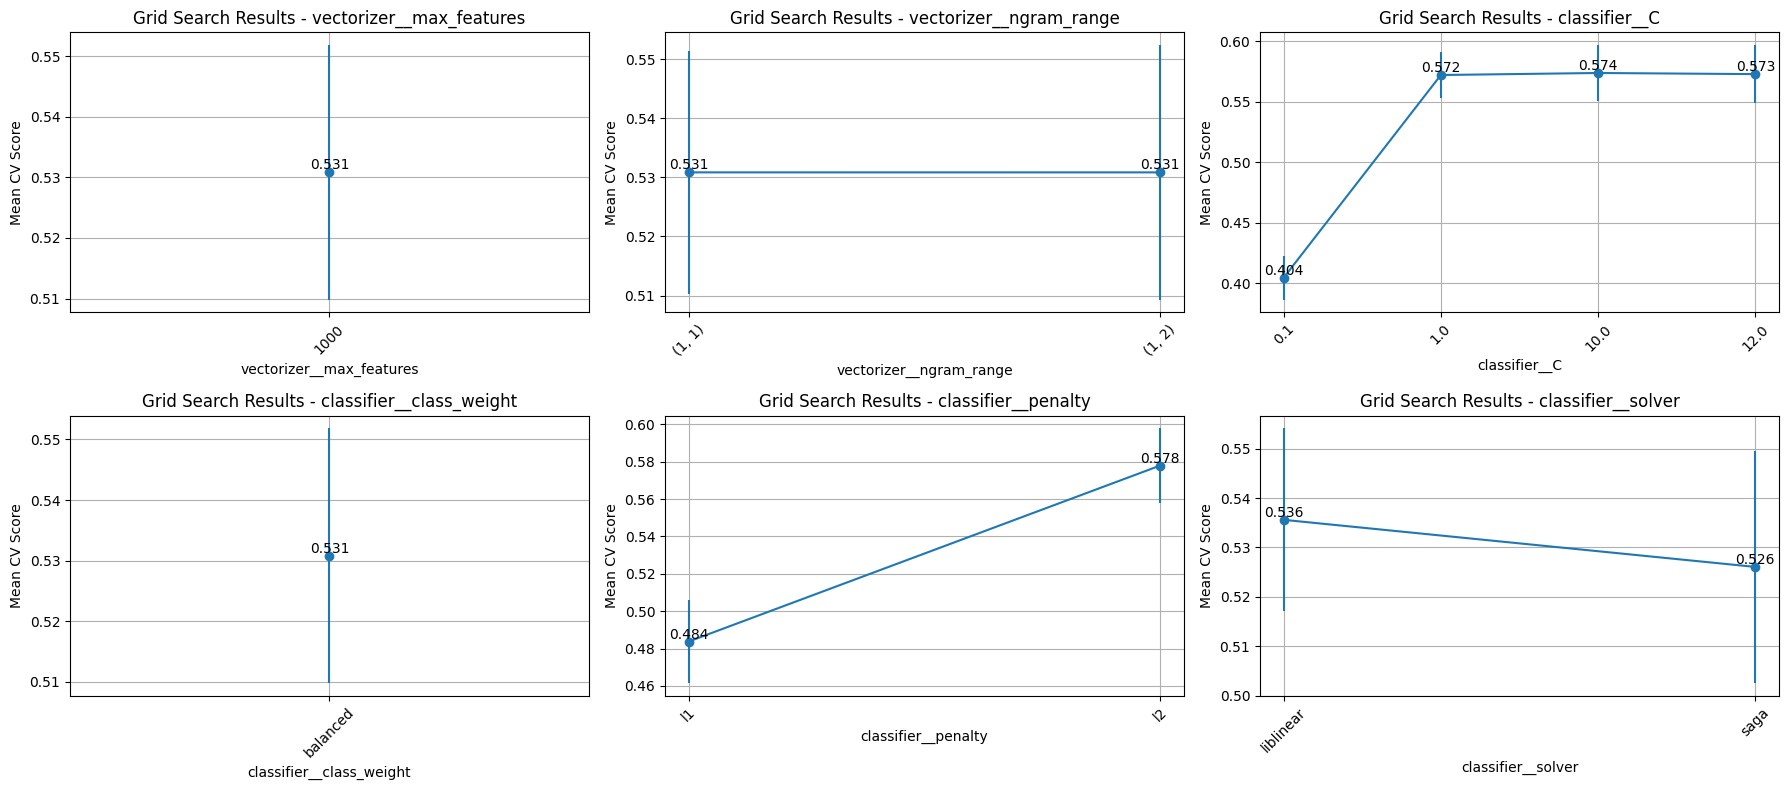


Top Features for Logistic Regression:


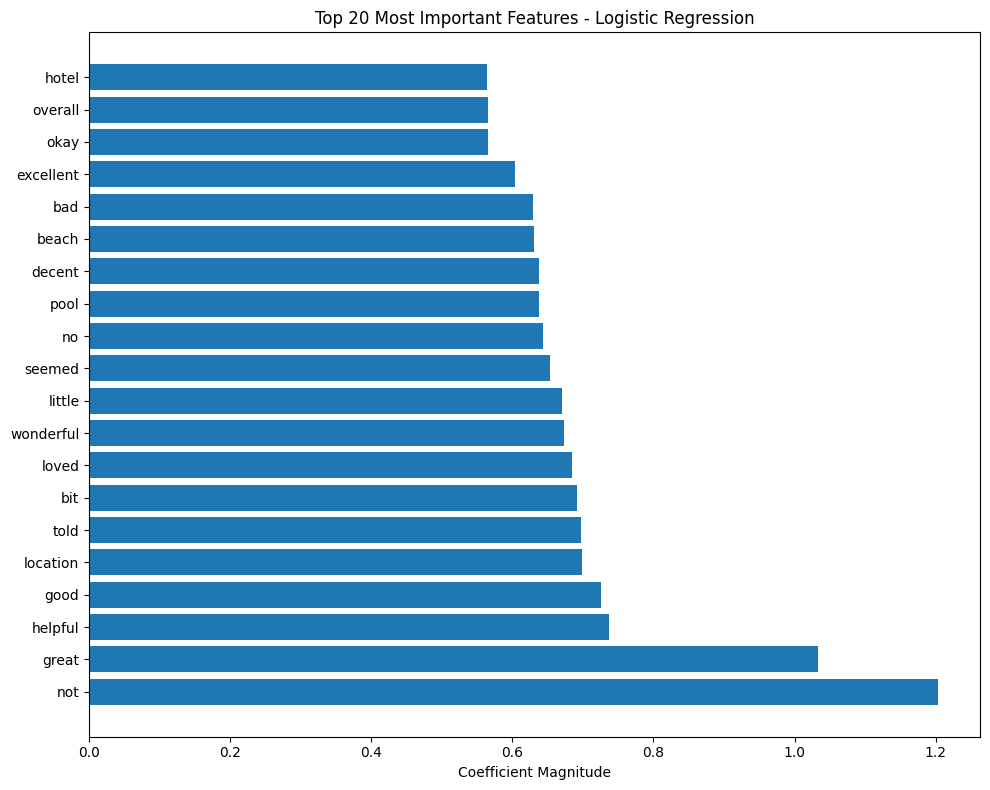


Class-specific Features for Logistic Regression:


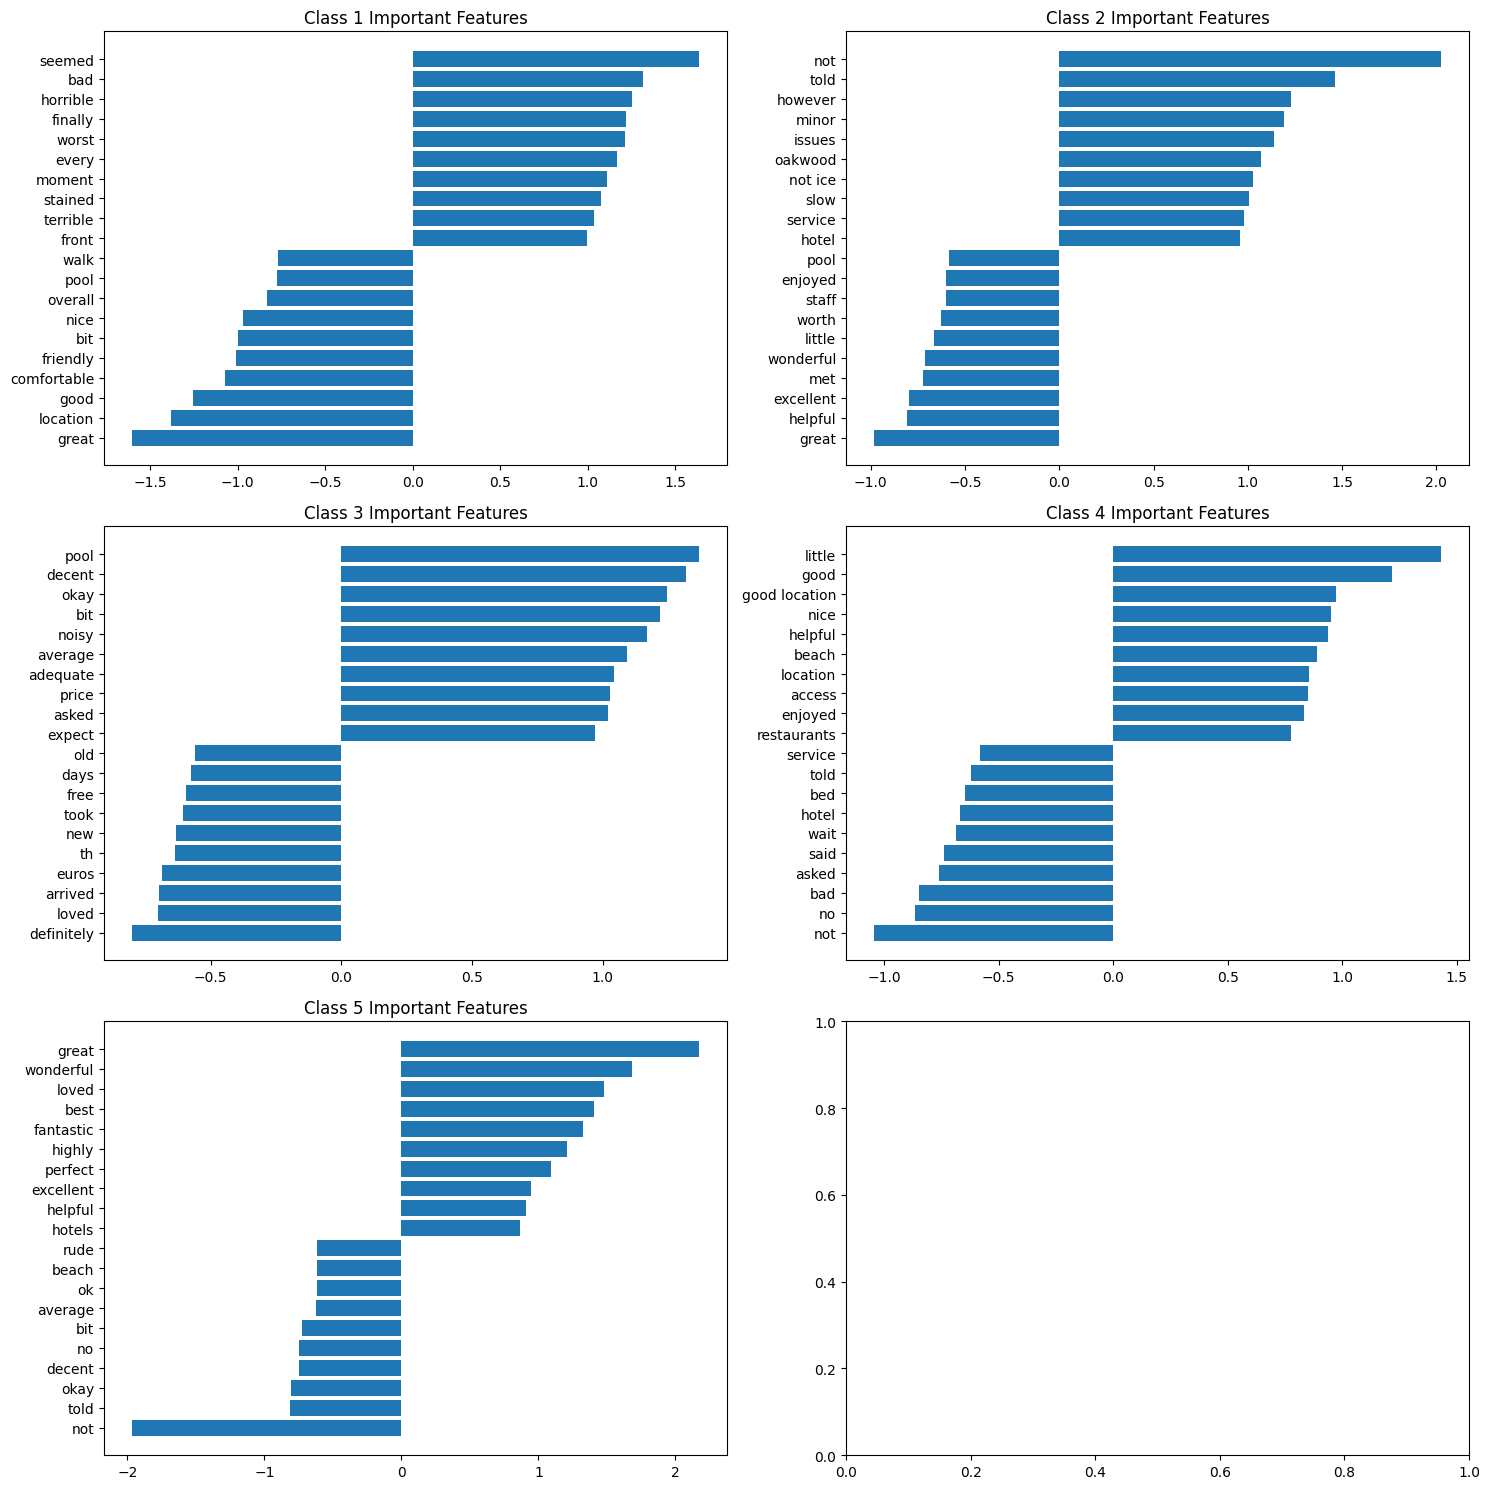


Training With Scaling with Grid Search...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

With Scaling Results:
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'scaler__with_mean': False, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.570
Training accuracy: 0.927
Testing accuracy: 0.595
Fit time: 0.809 seconds

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.72      0.75        25
           2       0.61      0.65      0.63        34
           3       0.36      0.50      0.42        24
           4       0.44      0.40      0.42        47
           5       0.74      0.69      0.71        70

    accuracy                           0.59       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.61      0.59      0.60       200



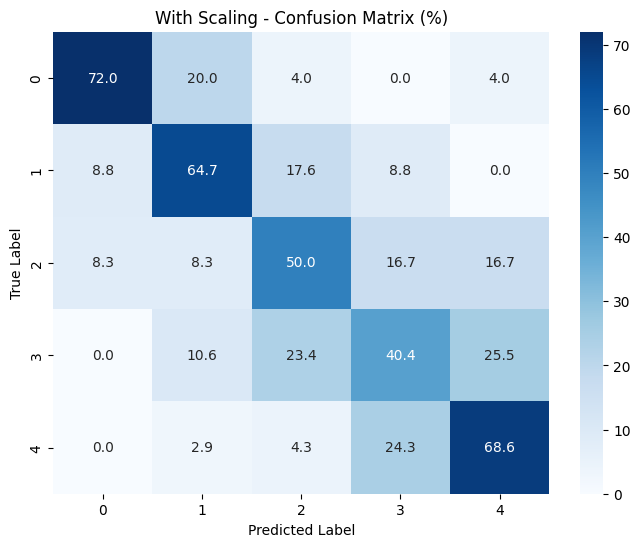

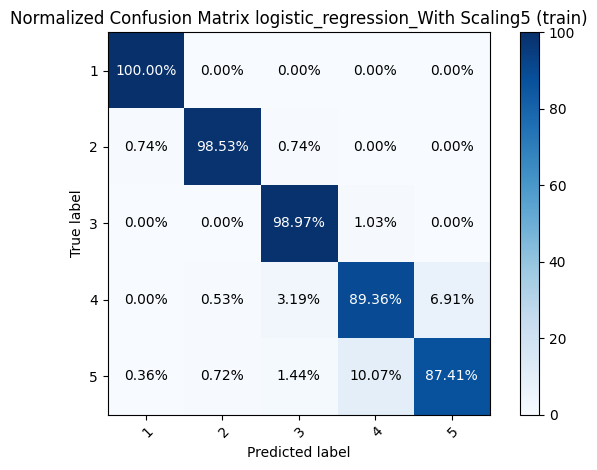

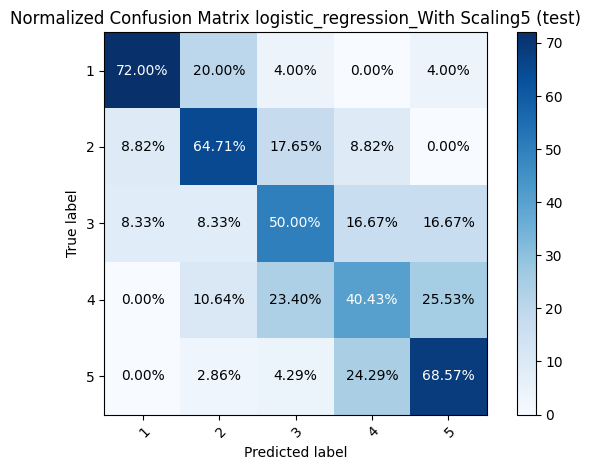

'Y Test'

(array([1, 2, 3, 4, 5]), array([25, 34, 24, 47, 70]))

'Y Test Predictions'

(array([1, 2, 3, 4, 5]), array([23, 36, 33, 43, 65]))

Score for logistic_regression_With Scaling5


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             1   0.782609  0.720000  0.750000     25.0       NaN         NaN   
1             2   0.611111  0.647059  0.628571     34.0       NaN         NaN   
2             3   0.363636  0.500000  0.421053     24.0       NaN         NaN   
3             4   0.441860  0.404255  0.422222     47.0       NaN         NaN   
4             5   0.738462  0.685714  0.711111     70.0       NaN         NaN   
5      accuracy        NaN       NaN       NaN      NaN     0.595         NaN   
6     macro avg   0.587536  0.591406  0.586591    200.0       NaN         NaN   
7  weighted avg   0.607650  0.595000  0.599245    200.0       NaN         NaN   
8    time_train        NaN       NaN       NaN      NaN       NaN    0.808574   

                             Modelo  
0  logistic_regression_With Scaling  
1  logistic_regression_With Scaling  
2  logistic_regression_With Scaling  
3  logistic_regression_With Scaling  
4  logistic_regression_With Scaling  
5  logistic_regression_With Scaling  
6  logistic_regression_With Scaling  
7  logistic_regression_With Scaling  
8  logistic_regression_With Scaling

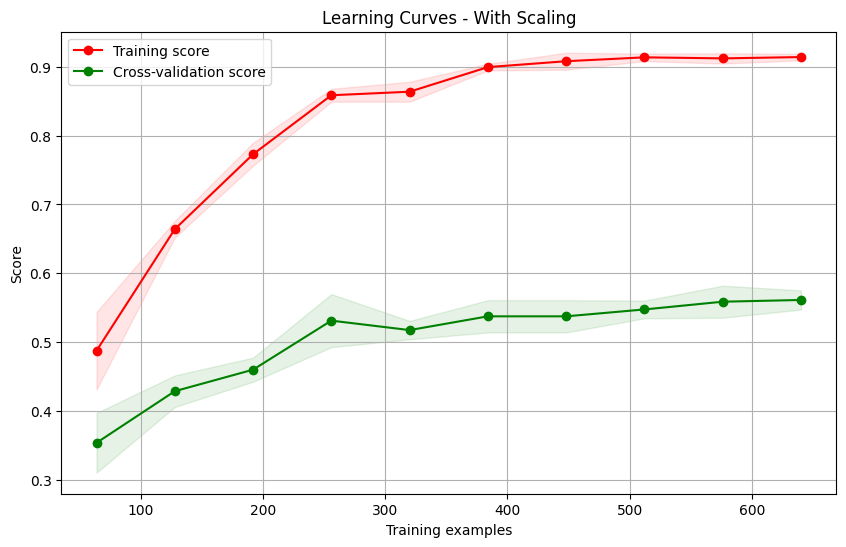


Grid Search Results for With Scaling:


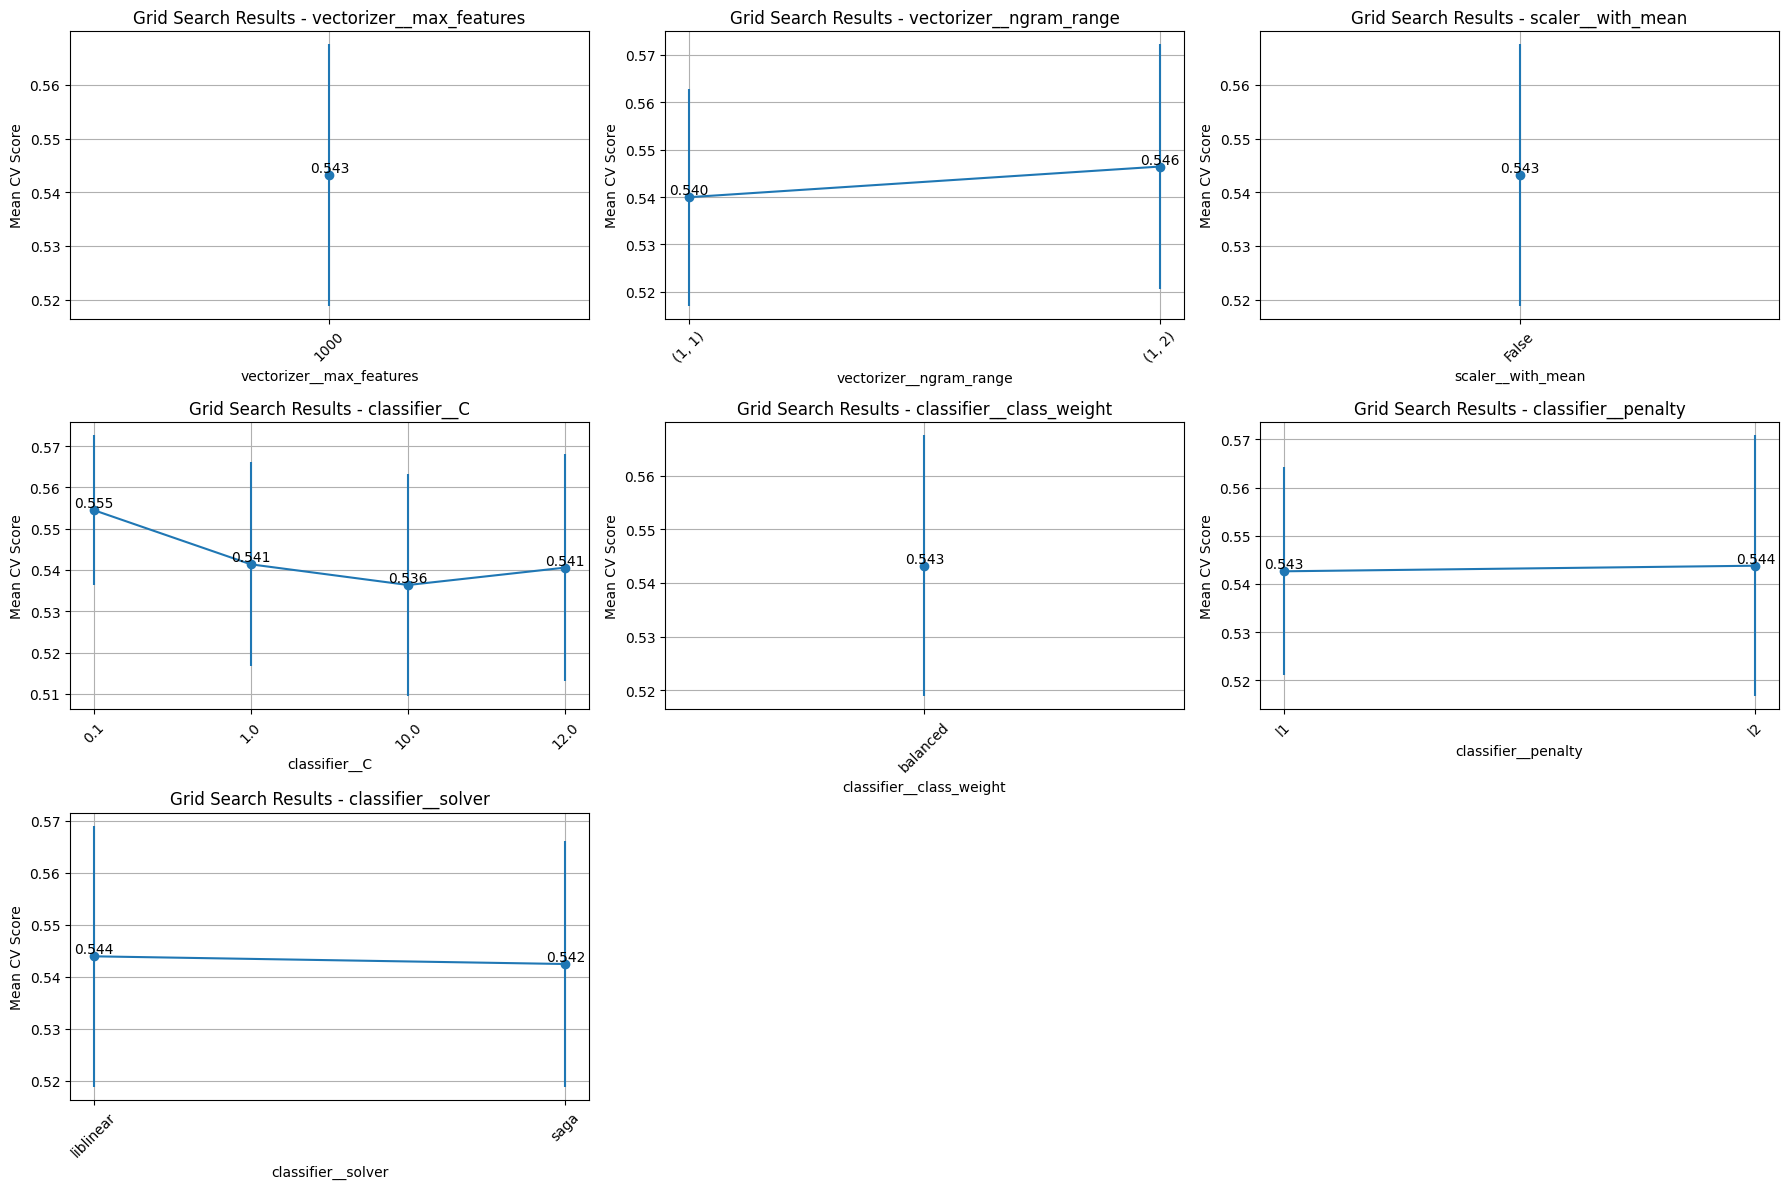


Top Features for With Scaling:
Could not plot feature importance for With Scaling: local variable 'importances' referenced before assignment

Class-specific Features for With Scaling:

Training With PCA with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

With PCA Results:
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 100, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.605
Training accuracy: 0.780
Testing accuracy: 0.545
Fit time: 0.363 seconds

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.76      0.73        25
           2       0.67      0.65      0.66        34
           3       0.35      0.38      0.36        24
           4       0.32      0.30      0.31        47
           5       0.64      0.64      0.64        70

 

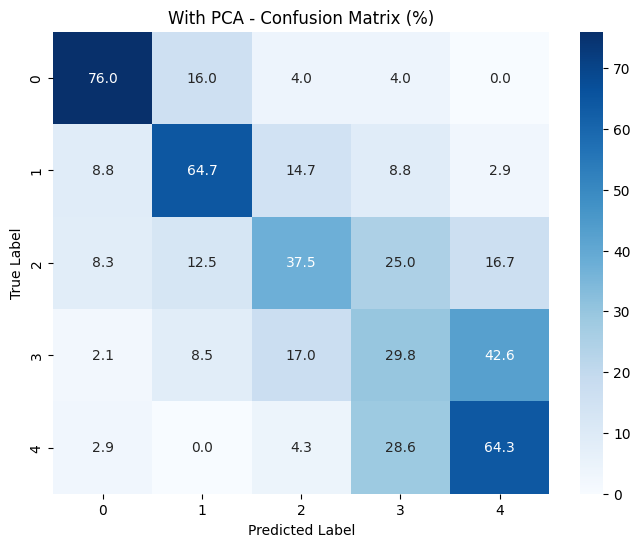

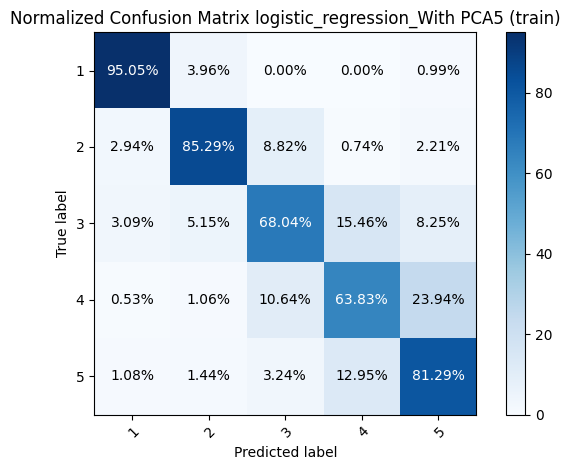

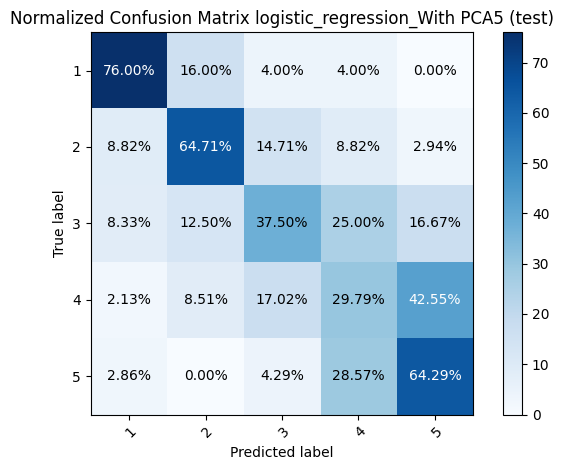

'Y Test'

(array([1, 2, 3, 4, 5]), array([25, 34, 24, 47, 70]))

'Y Test Predictions'

(array([1, 2, 3, 4, 5]), array([27, 33, 26, 44, 70]))

Score for logistic_regression_With PCA5


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             1   0.703704  0.760000  0.730769     25.0       NaN         NaN   
1             2   0.666667  0.647059  0.656716     34.0       NaN         NaN   
2             3   0.346154  0.375000  0.360000     24.0       NaN         NaN   
3             4   0.318182  0.297872  0.307692     47.0       NaN         NaN   
4             5   0.642857  0.642857  0.642857     70.0       NaN         NaN   
5      accuracy        NaN       NaN       NaN      NaN     0.545         NaN   
6     macro avg   0.535513  0.544558  0.539607    200.0       NaN         NaN   
7  weighted avg   0.542607  0.545000  0.543496    200.0       NaN         NaN   
8    time_train        NaN       NaN       NaN      NaN       NaN    0.363222   

                         Modelo  
0  logistic_regression_With PCA  
1  logistic_regression_With PCA  
2  logistic_regression_With PCA  
3  logistic_regression_With PCA  
4  logistic_regression_With PCA  
5  logistic_regression_With PCA  
6  logistic_regression_With PCA  
7  logistic_regression_With PCA  
8  logistic_regression_With PCA

/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/pipeline.py"

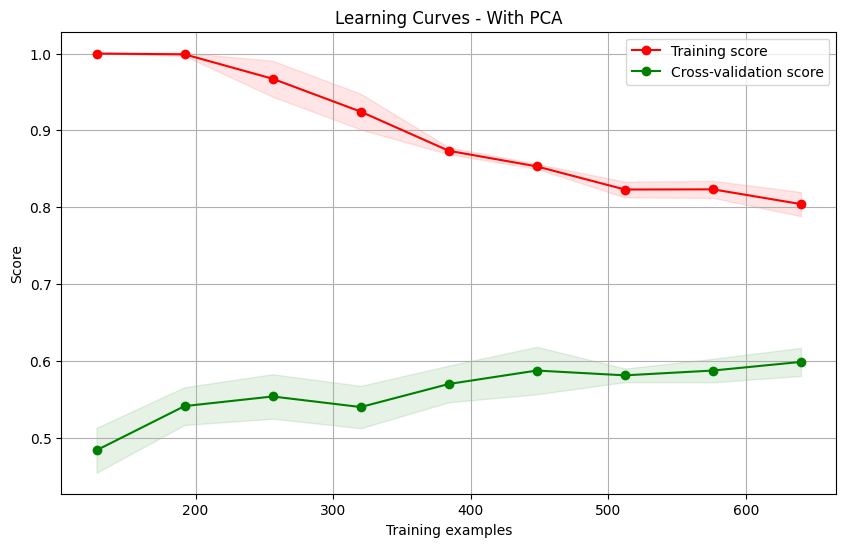


Grid Search Results for With PCA:


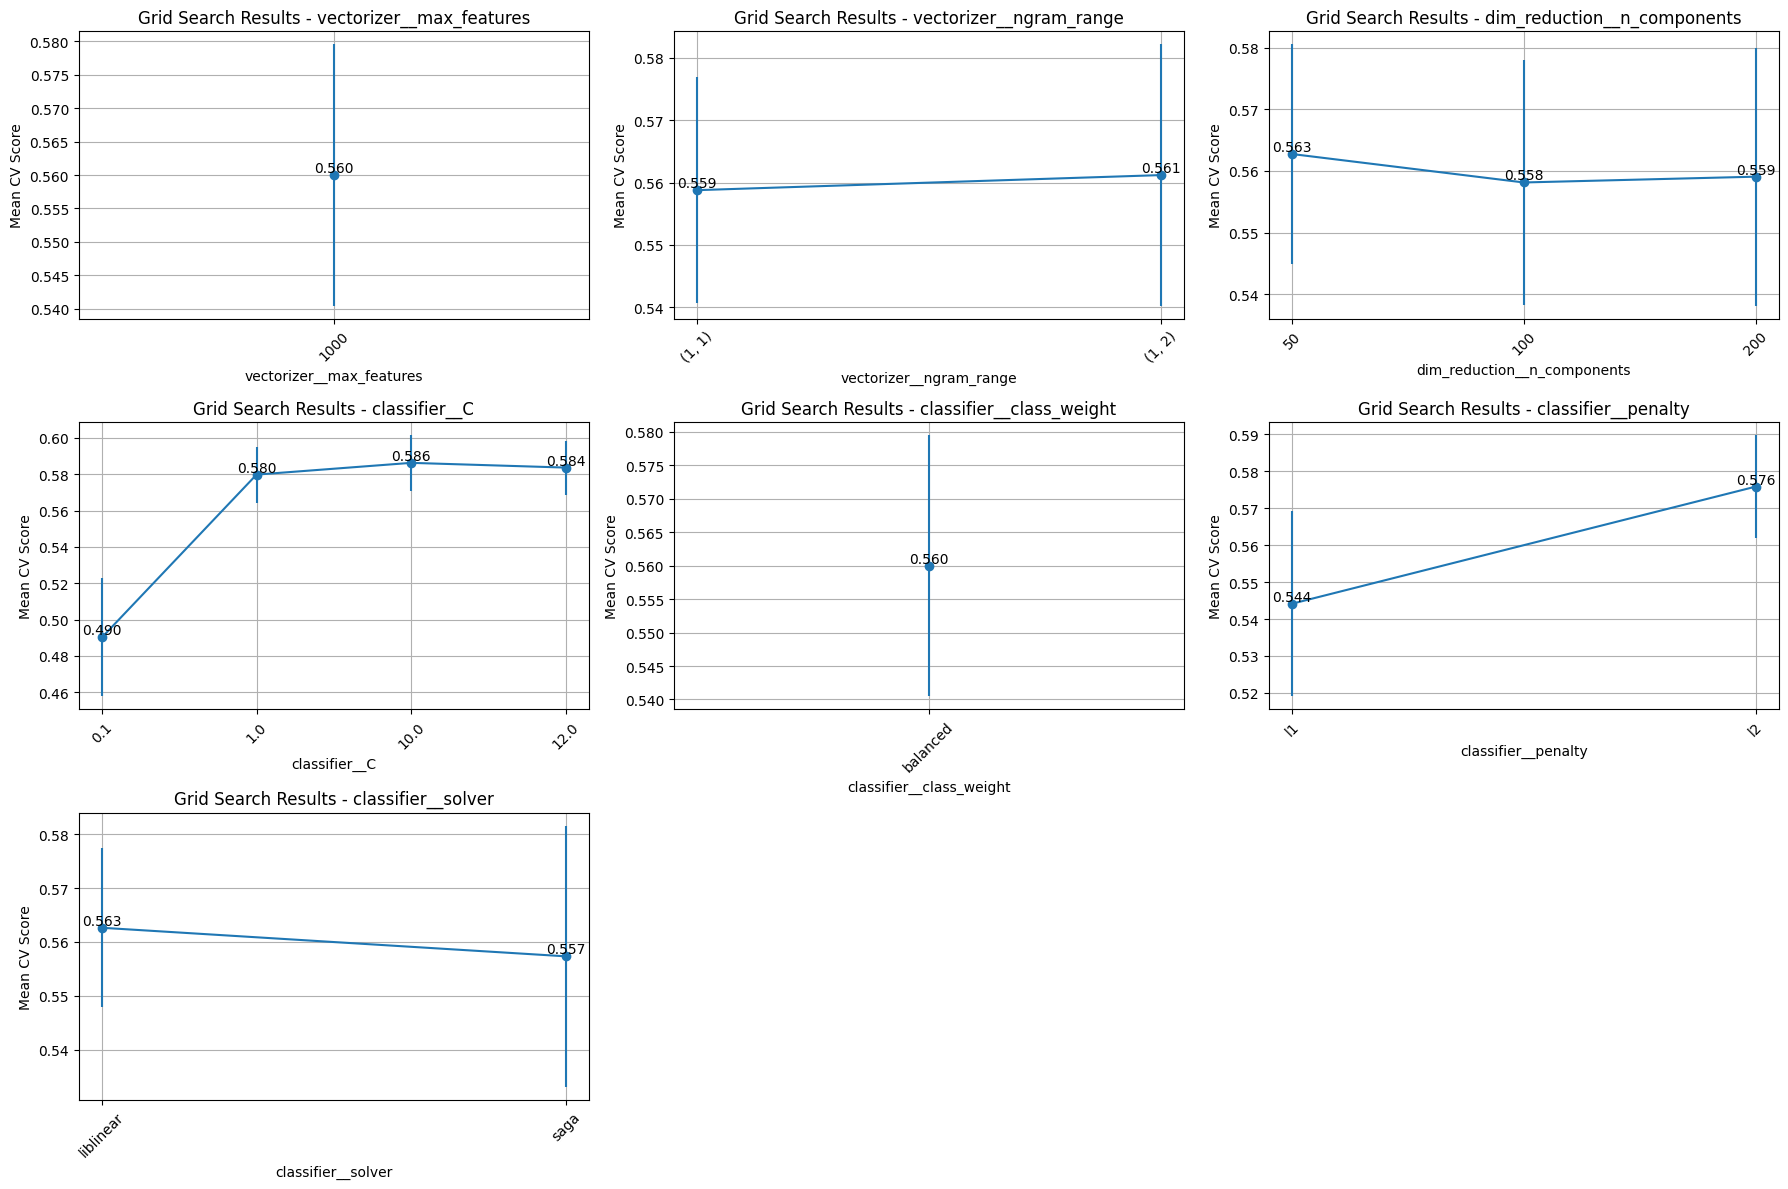


Top Features for With PCA:
Could not plot feature importance for With PCA: local variable 'importances' referenced before assignment

Class-specific Features for With PCA:

Training PCA + Scaling with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


PCA + Scaling Results:
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 50, 'scaler__with_mean': False, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.605
Training accuracy: 0.701
Testing accuracy: 0.575
Fit time: 0.375 seconds

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.76      0.75        25
           2       0.71      0.59      0.65        34
           3       0.39      0.46      0.42        24
           4       0.39      0.36      0.37        47
           5       0.65      0.69      0.67        70

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200



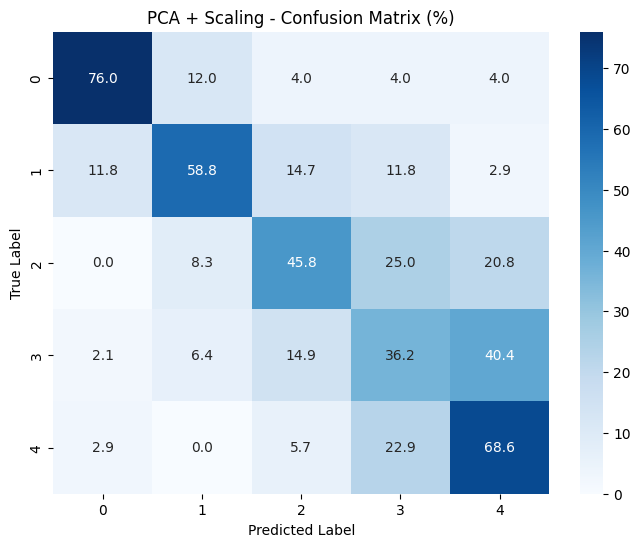

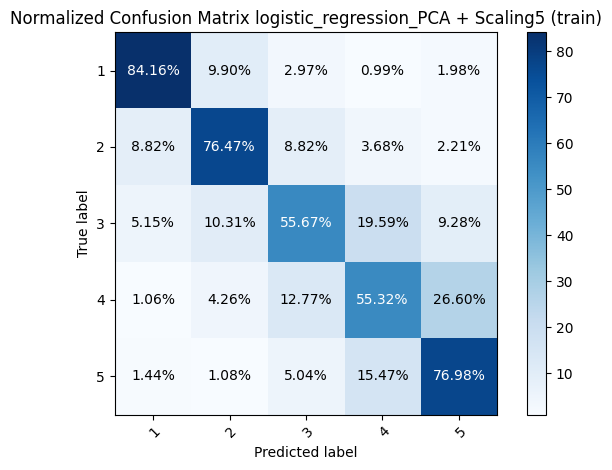

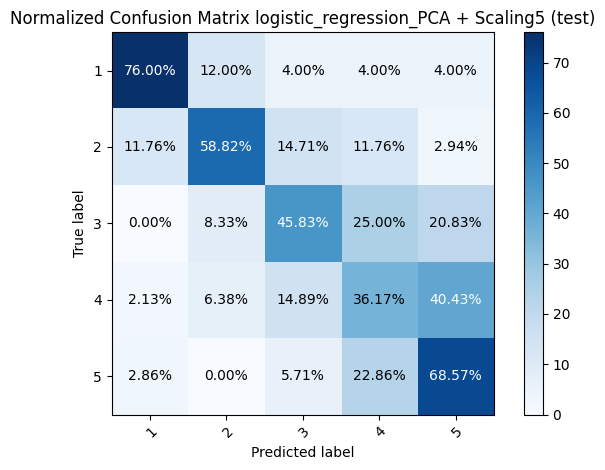

'Y Test'

(array([1, 2, 3, 4, 5]), array([25, 34, 24, 47, 70]))

'Y Test Predictions'

(array([1, 2, 3, 4, 5]), array([26, 28, 28, 44, 74]))

Score for logistic_regression_PCA + Scaling5


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             1   0.730769  0.760000  0.745098     25.0       NaN         NaN   
1             2   0.714286  0.588235  0.645161     34.0       NaN         NaN   
2             3   0.392857  0.458333  0.423077     24.0       NaN         NaN   
3             4   0.386364  0.361702  0.373626     47.0       NaN         NaN   
4             5   0.648649  0.685714  0.666667     70.0       NaN         NaN   
5      accuracy        NaN       NaN       NaN      NaN     0.575         NaN   
6     macro avg   0.574585  0.570797  0.570726    200.0       NaN         NaN   
7  weighted avg   0.577740  0.575000  0.574719    200.0       NaN         NaN   
8    time_train        NaN       NaN       NaN      NaN       NaN     0.37487   

                              Modelo  
0  logistic_regression_PCA + Scaling  
1  logistic_regression_PCA + Scaling  
2  logistic_regression_PCA + Scaling  
3  logistic_regression_PCA + Scaling  
4  logistic_regression_PCA + Scaling  
5  logistic_regression_PCA + Scaling  
6  logistic_regression_PCA + Scaling  
7  logistic_regression_PCA + Scaling  
8  logistic_regression_PCA + Scaling

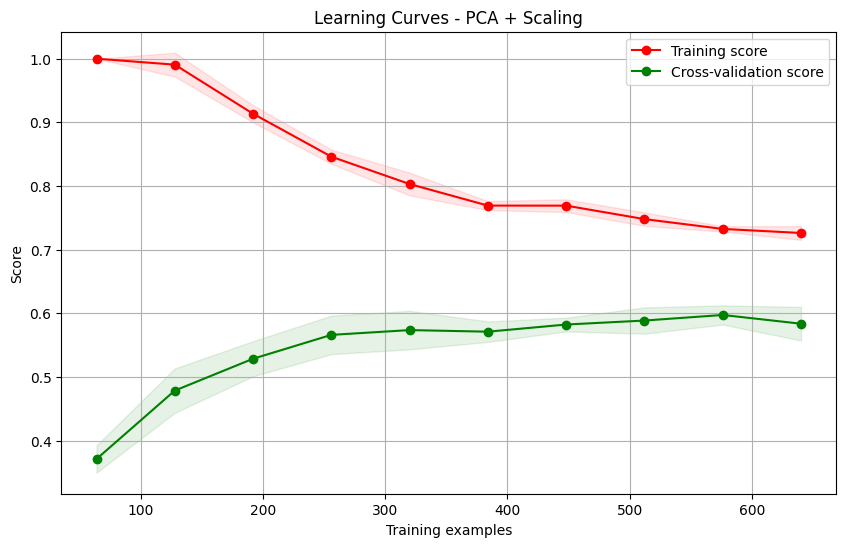


Grid Search Results for PCA + Scaling:


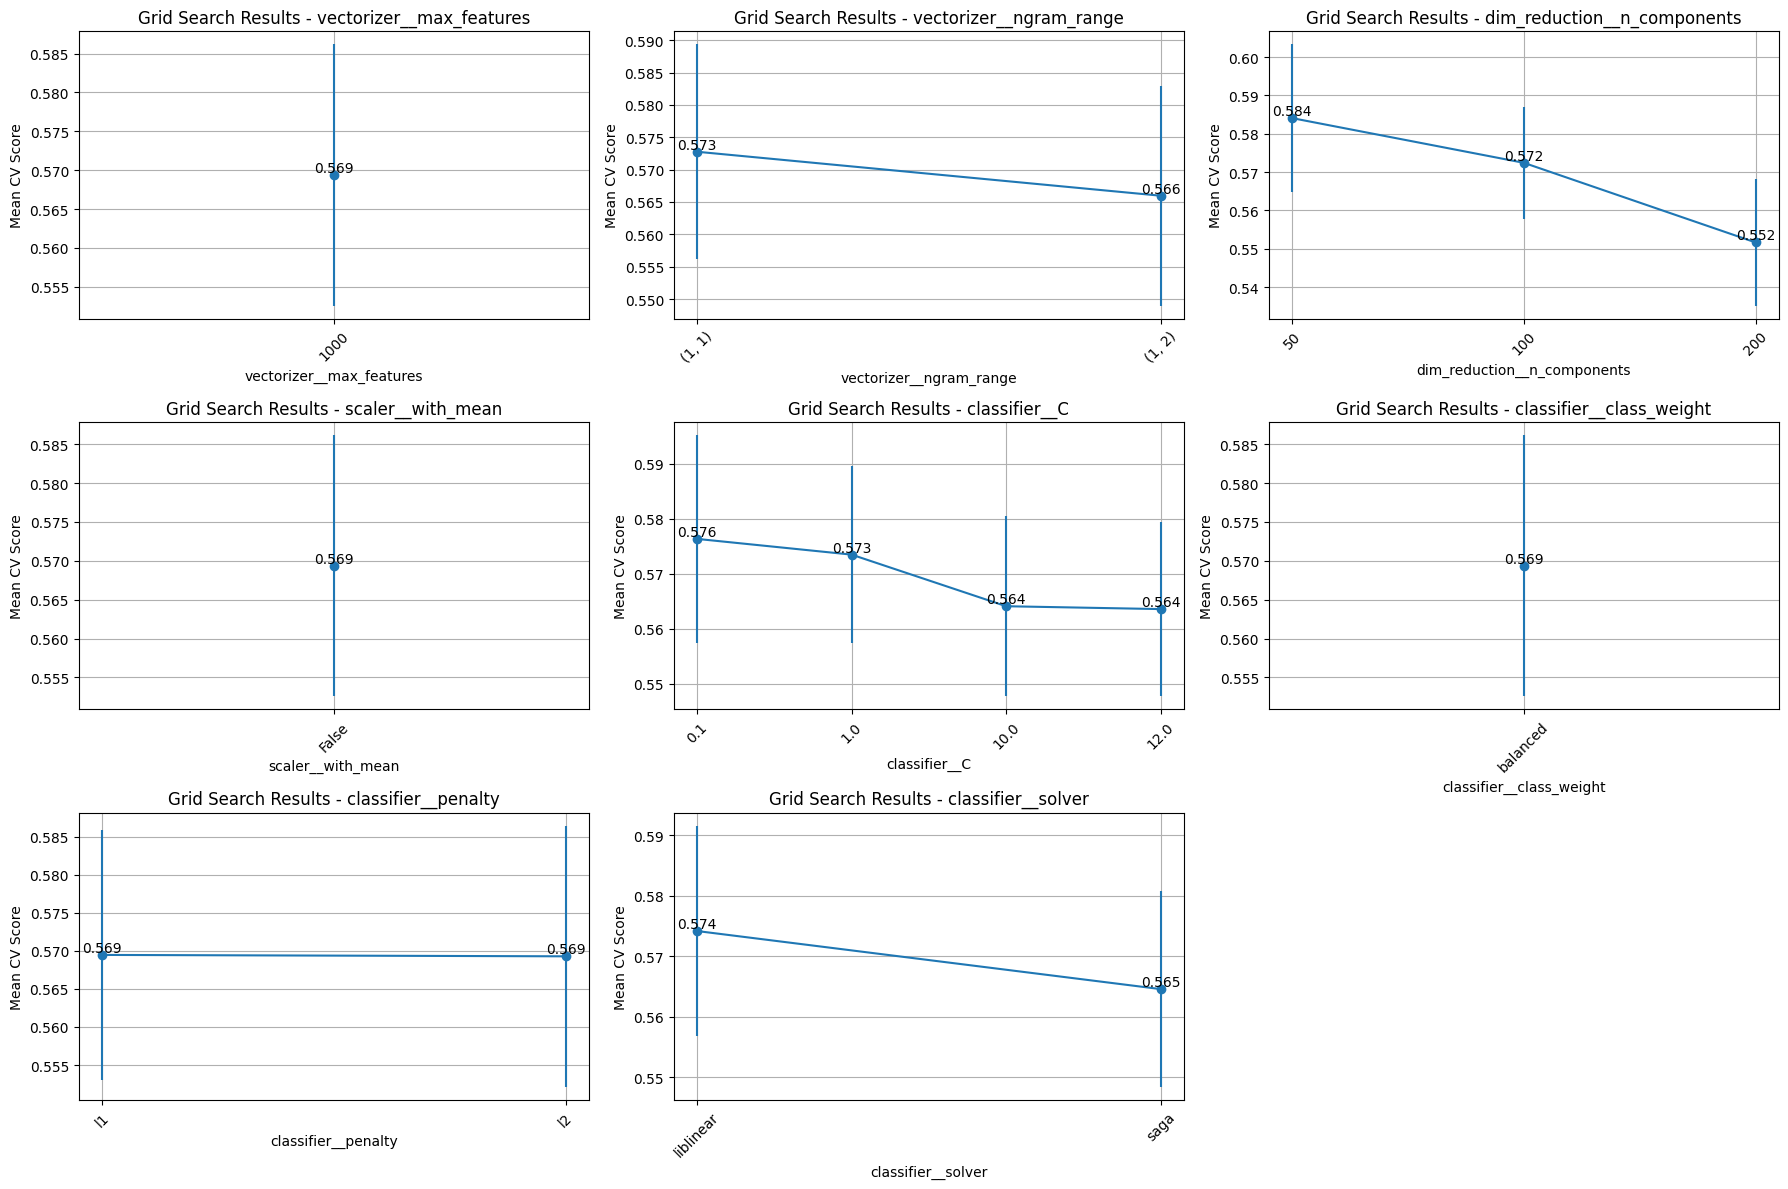


Top Features for PCA + Scaling:
Could not plot feature importance for PCA + Scaling: local variable 'importances' referenced before assignment

Class-specific Features for PCA + Scaling:


In [10]:
# Compare models
results = compare_models_with_grid_search(X_train, X_test, y_train, y_test, classes="5")

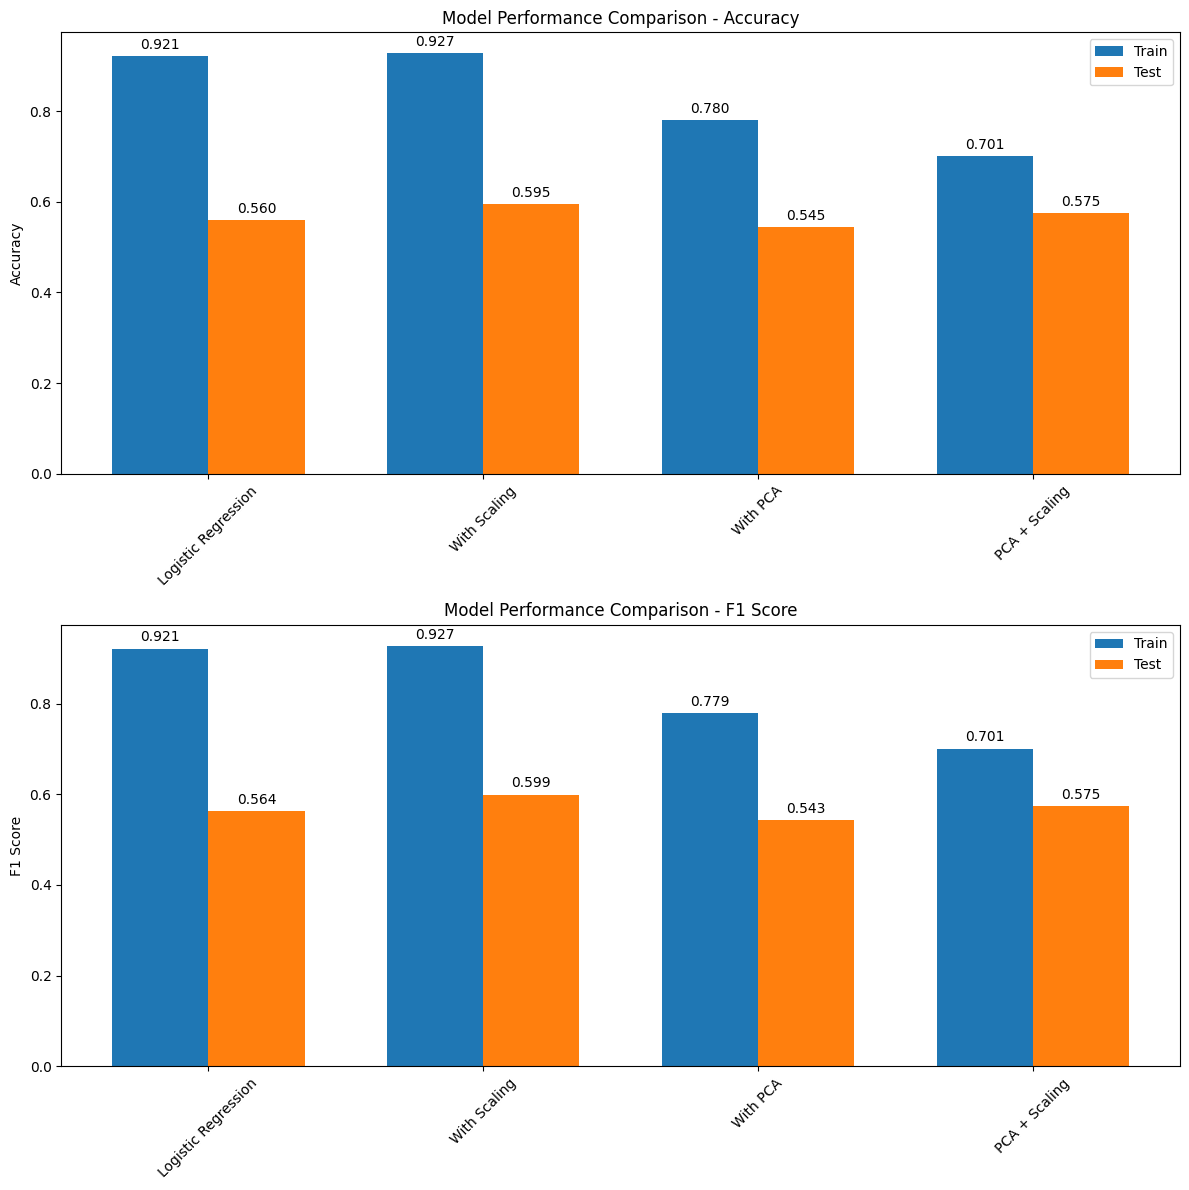

In [11]:
# Plot comparison
plot_model_comparison(results)

### Tres Clases


Training Logistic Regression with Grid Search...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Results:
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.832
Training accuracy: 1.000
Testing accuracy: 0.820
Fit time: 0.082 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        59
           1       0.32      0.29      0.30        24
           2       0.90      0.91      0.91       117

    accuracy                           0.82       200
   macro avg       0.69      0.68      0.69       200
weighted avg       0.81      0.82      0.82       200



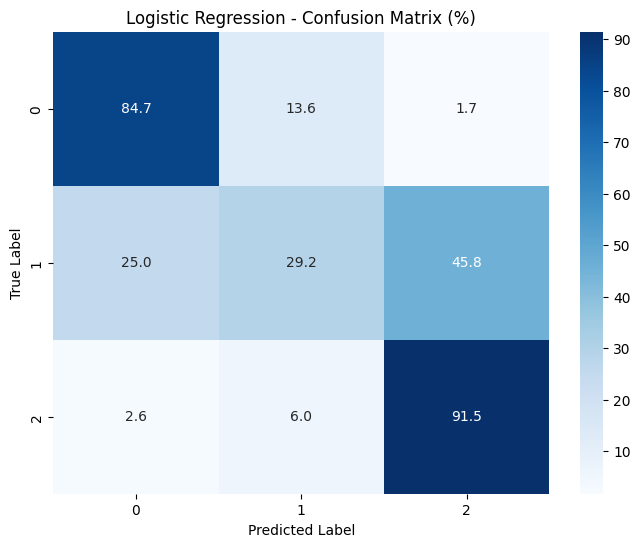

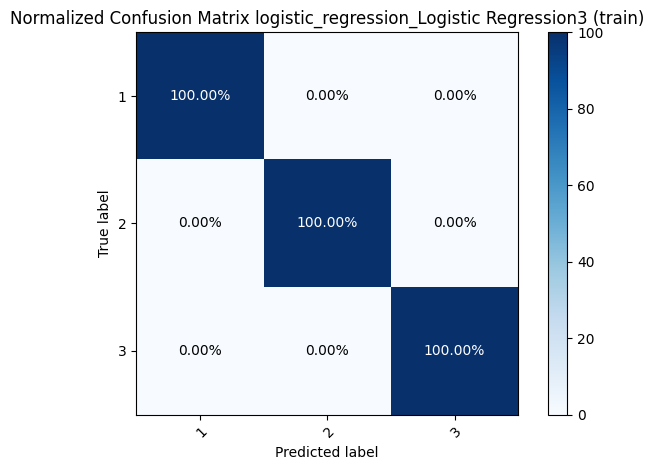

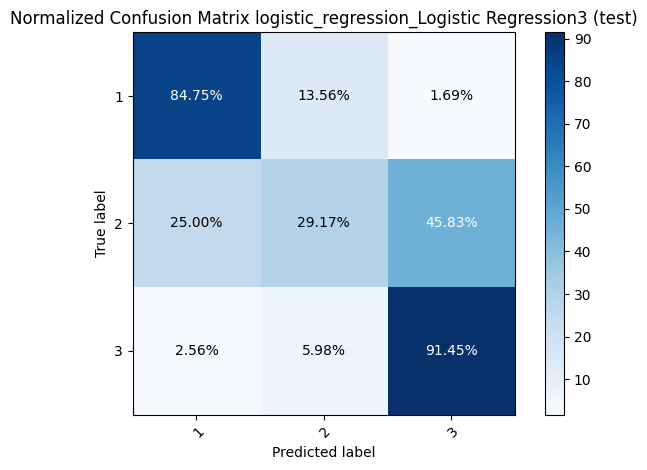

'Y Test'

(array([0, 1, 2]), array([ 59,  24, 117]))

'Y Test Predictions'

(array([0, 1, 2]), array([ 59,  22, 119]))

Score for logistic_regression_Logistic Regression3


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             0   0.847458  0.847458  0.847458     59.0       NaN         NaN   
1             1   0.318182  0.291667  0.304348     24.0       NaN         NaN   
2             2   0.899160  0.914530  0.906780    117.0       NaN         NaN   
3      accuracy        NaN       NaN       NaN      NaN      0.82         NaN   
4     macro avg   0.688266  0.684551  0.686195    200.0       NaN         NaN   
5  weighted avg   0.814190  0.820000  0.816988    200.0       NaN         NaN   
6    time_train        NaN       NaN       NaN      NaN       NaN    0.081631   

                                    Modelo  
0  logistic_regression_Logistic Regression  
1  logistic_regression_Logistic Regression  
2  logistic_regression_Logistic Regression  
3  logistic_regression_Logistic Regression  
4  logistic_regression_Logistic Regression  
5  logistic_regression_Logistic Regression  
6  logistic_regression_Logistic Regression


Grid Search Results for Logistic Regression:


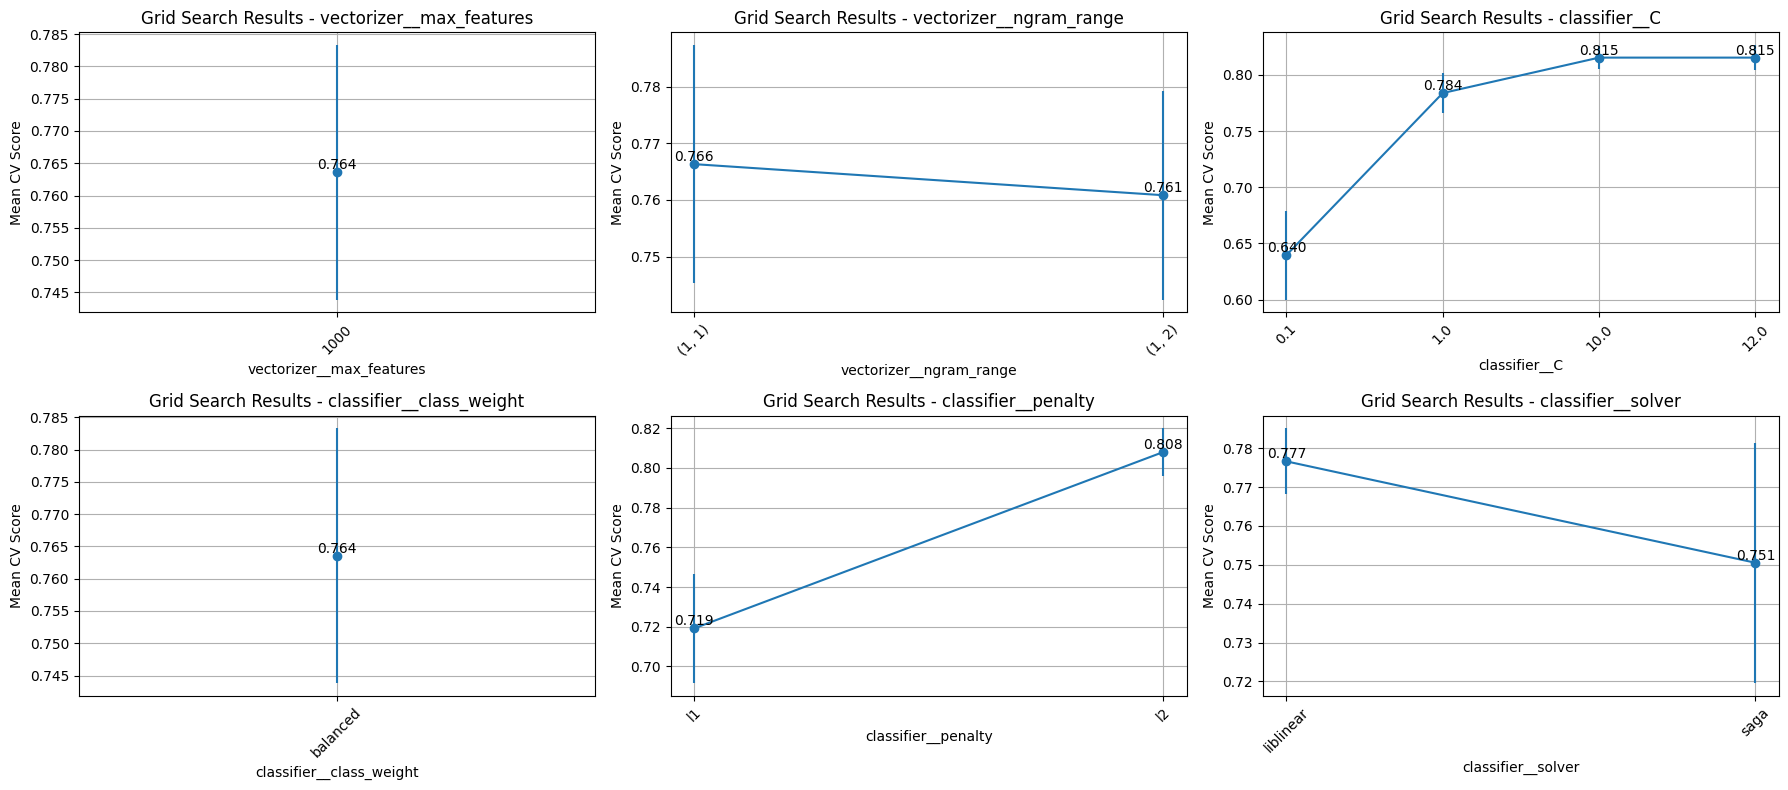


Top Features for Logistic Regression:


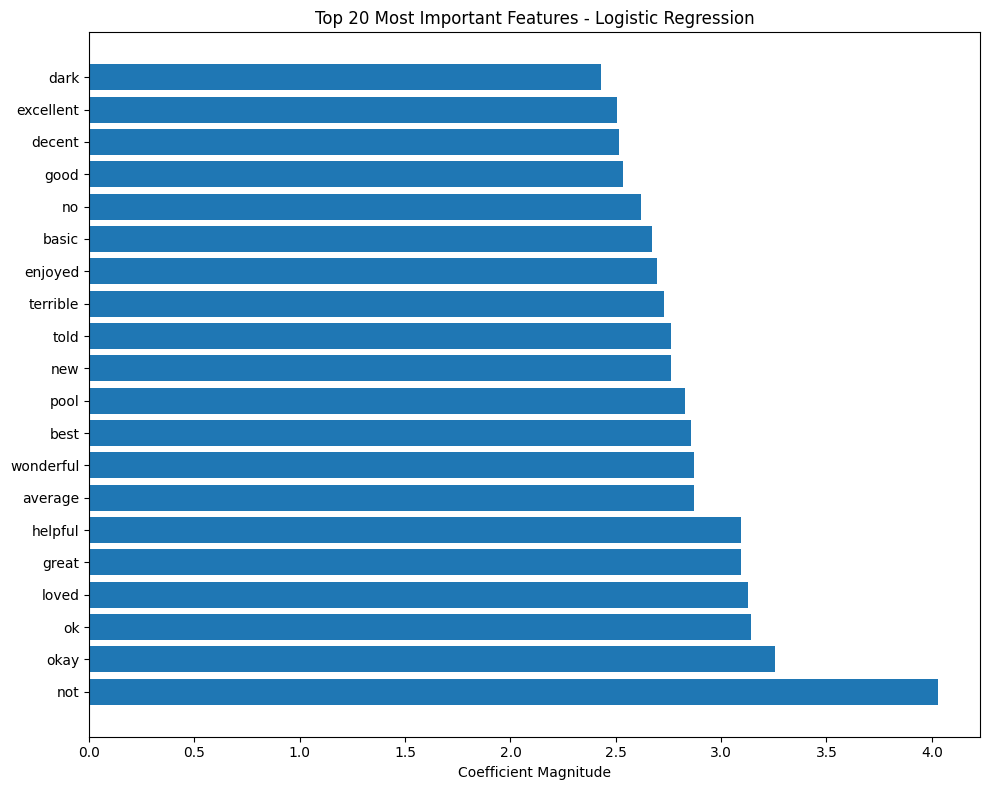


Class-specific Features for Logistic Regression:


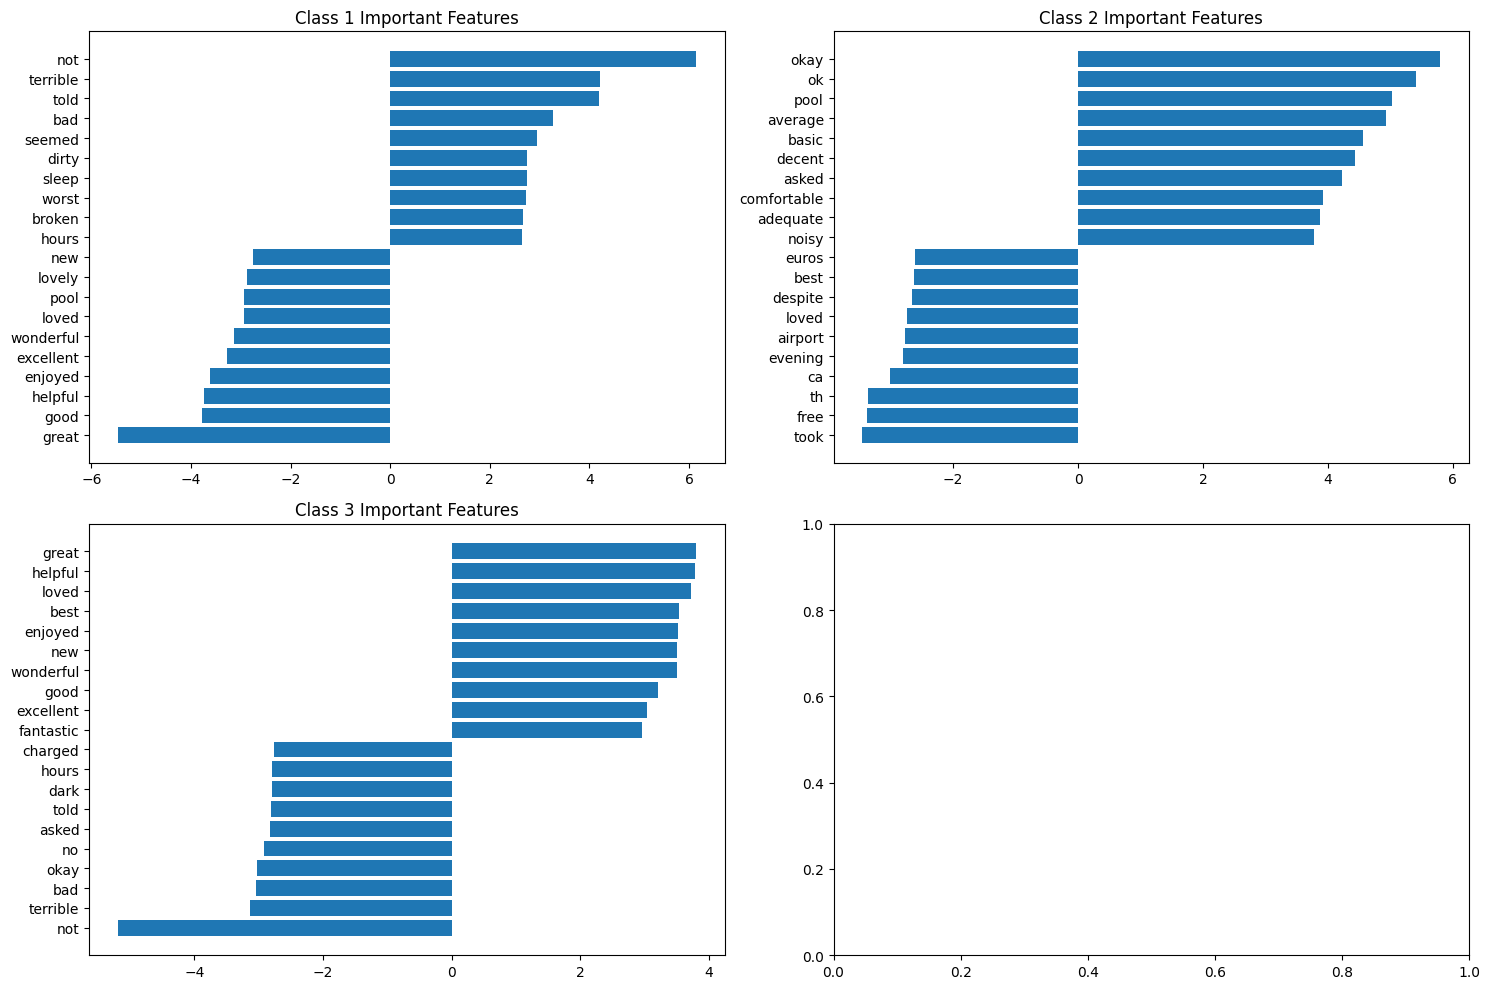


Training With Scaling with Grid Search...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

With Scaling Results:
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'scaler__with_mean': False, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.816
Training accuracy: 1.000
Testing accuracy: 0.785
Fit time: 0.206 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        59
           1       0.24      0.25      0.24        24
           2       0.89      0.88      0.88       117

    accuracy                           0.79       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.79      0.79      0.79       200



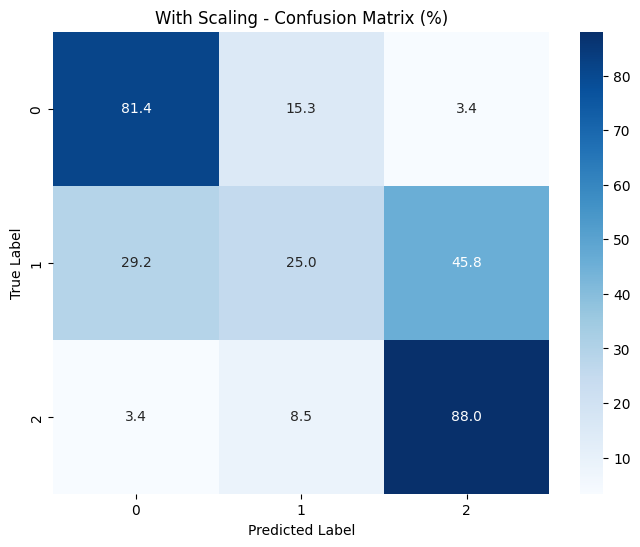

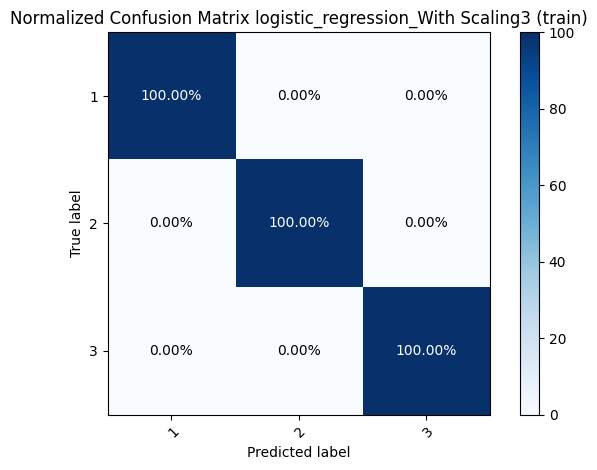

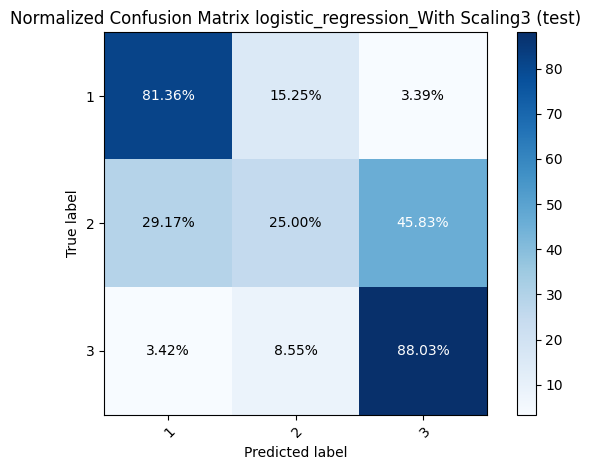

'Y Test'

(array([0, 1, 2]), array([ 59,  24, 117]))

'Y Test Predictions'

(array([0, 1, 2]), array([ 59,  25, 116]))

Score for logistic_regression_With Scaling3


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             0   0.813559  0.813559  0.813559     59.0       NaN         NaN   
1             1   0.240000  0.250000  0.244898     24.0       NaN         NaN   
2             2   0.887931  0.880342  0.884120    117.0       NaN         NaN   
3      accuracy        NaN       NaN       NaN      NaN     0.785         NaN   
4     macro avg   0.647163  0.647967  0.647526    200.0       NaN         NaN   
5  weighted avg   0.788240  0.785000  0.786598    200.0       NaN         NaN   
6    time_train        NaN       NaN       NaN      NaN       NaN    0.206287   

                             Modelo  
0  logistic_regression_With Scaling  
1  logistic_regression_With Scaling  
2  logistic_regression_With Scaling  
3  logistic_regression_With Scaling  
4  logistic_regression_With Scaling  
5  logistic_regression_With Scaling  
6  logistic_regression_With Scaling

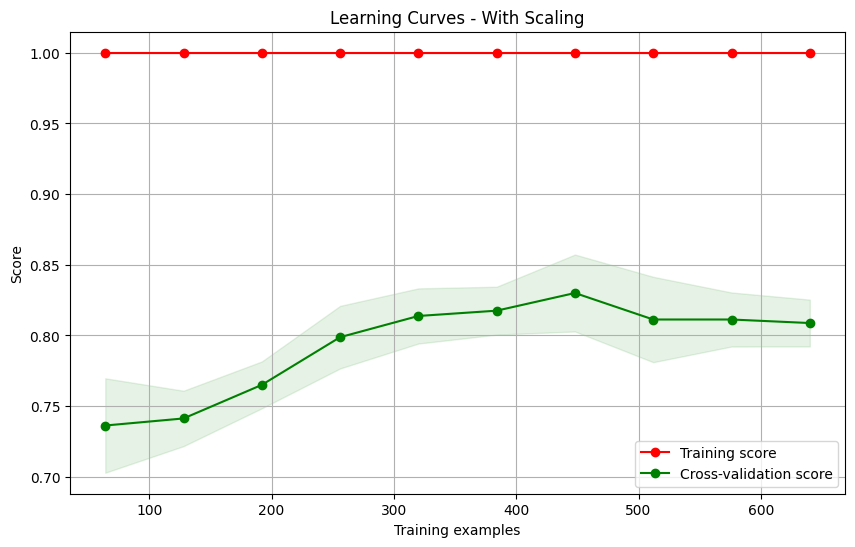


Grid Search Results for With Scaling:


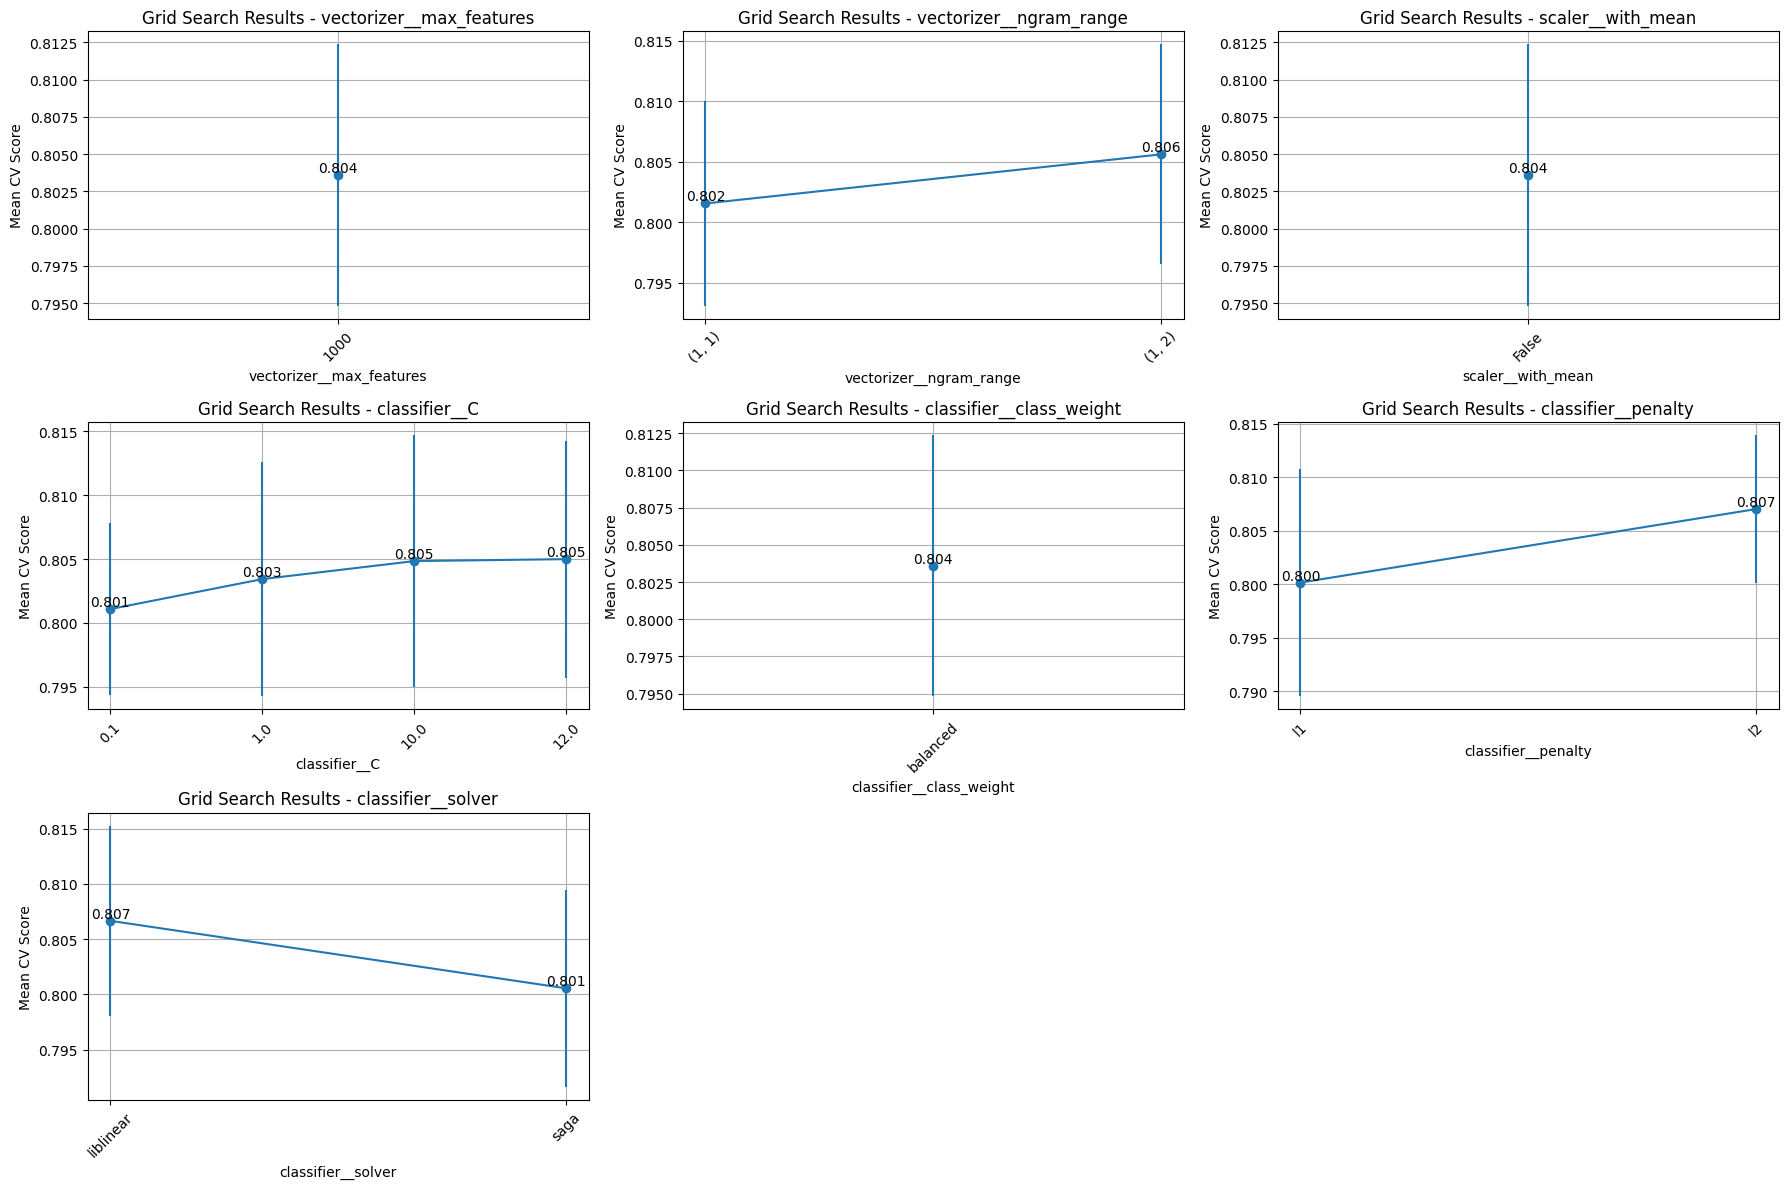


Top Features for With Scaling:
Could not plot feature importance for With Scaling: local variable 'importances' referenced before assignment

Class-specific Features for With Scaling:

Training With PCA with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


With PCA Results:
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 50, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.840
Training accuracy: 0.861
Testing accuracy: 0.810
Fit time: 0.320 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        59
           1       0.45      0.21      0.29        24
           2       0.84      0.93      0.89       117

    accuracy                           0.81       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.78      0.81      0.79       200



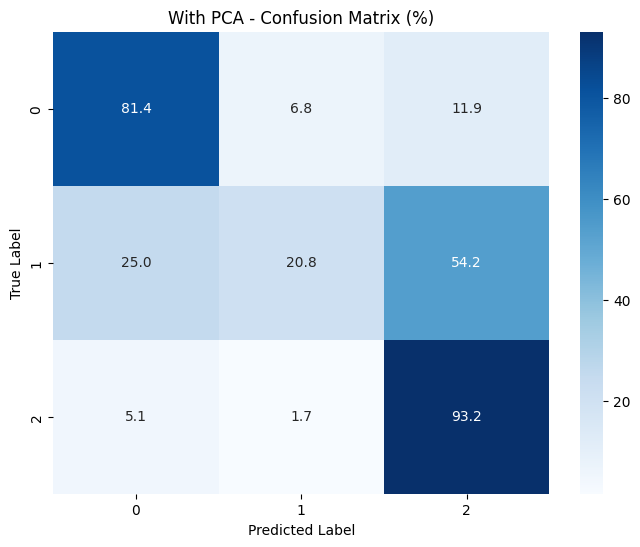

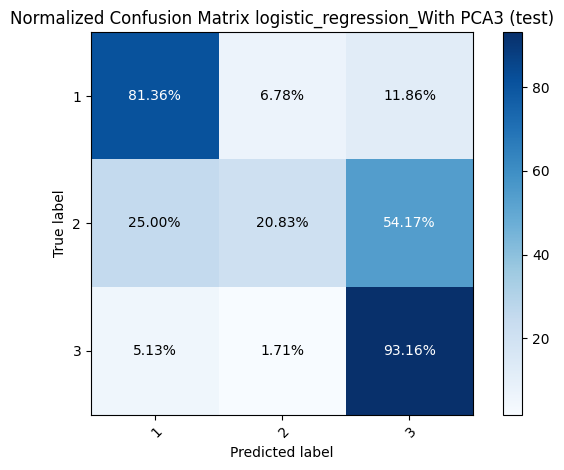

'Y Test'

(array([0, 1, 2]), array([ 59,  24, 117]))

'Y Test Predictions'

(array([0, 1, 2]), array([ 60,  11, 129]))

Score for logistic_regression_With PCA3


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             0   0.800000  0.813559  0.806723     59.0       NaN         NaN   
1             1   0.454545  0.208333  0.285714     24.0       NaN         NaN   
2             2   0.844961  0.931624  0.886179    117.0       NaN         NaN   
3      accuracy        NaN       NaN       NaN      NaN      0.81         NaN   
4     macro avg   0.699836  0.651172  0.659539    200.0       NaN         NaN   
5  weighted avg   0.784848  0.810000  0.790684    200.0       NaN         NaN   
6    time_train        NaN       NaN       NaN      NaN       NaN    0.319588   

                         Modelo  
0  logistic_regression_With PCA  
1  logistic_regression_With PCA  
2  logistic_regression_With PCA  
3  logistic_regression_With PCA  
4  logistic_regression_With PCA  
5  logistic_regression_With PCA  
6  logistic_regression_With PCA

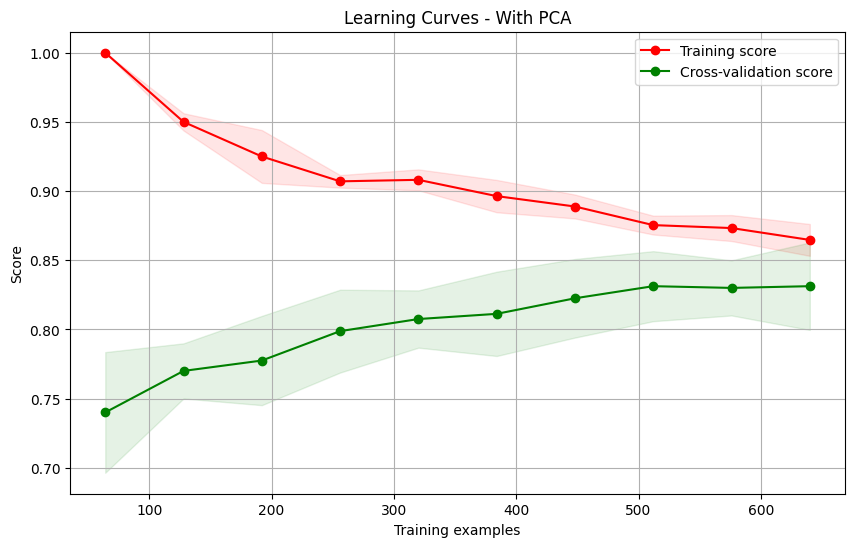


Grid Search Results for With PCA:


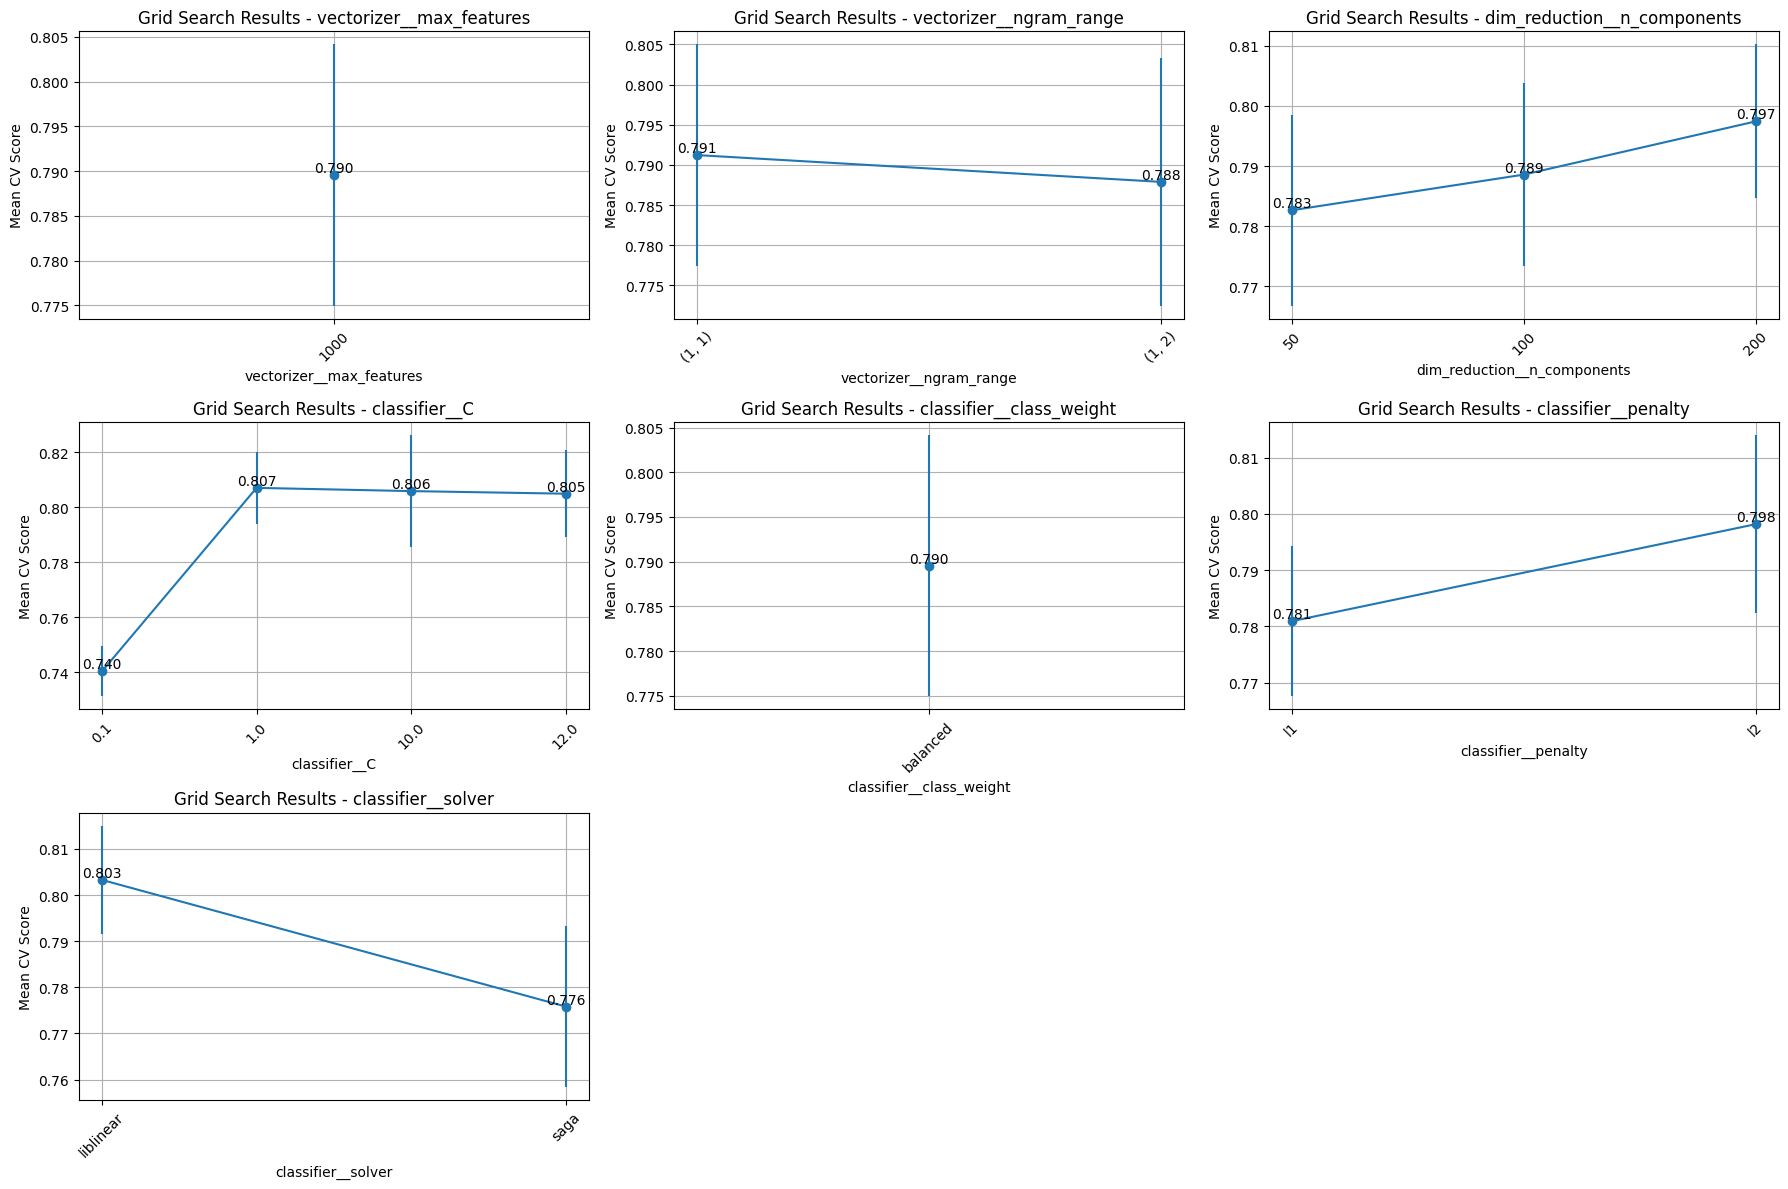


Top Features for With PCA:
Could not plot feature importance for With PCA: local variable 'importances' referenced before assignment

Class-specific Features for With PCA:

Training PCA + Scaling with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


PCA + Scaling Results:
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 100, 'scaler__with_mean': False, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.835
Training accuracy: 0.870
Testing accuracy: 0.830
Fit time: 0.162 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        59
           1       0.57      0.33      0.42        24
           2       0.86      0.94      0.90       117

    accuracy                           0.83       200
   macro avg       0.75      0.70      0.71       200
weighted avg       0.82      0.83      0.82       200



'Y Test'

(array([0, 1, 2]), array([ 59,  24, 117]))

'Y Test Predictions'

(array([0, 1, 2]), array([ 58,  14, 128]))

Score for logistic_regression_PCA + Scaling3


Clase  precision    recall  f1-score  support  accuracy  time_train  \
0             0   0.827586  0.813559  0.820513     59.0       NaN         NaN   
1             1   0.571429  0.333333  0.421053     24.0       NaN         NaN   
2             2   0.859375  0.940171  0.897959    117.0       NaN         NaN   
3      accuracy        NaN       NaN       NaN      NaN      0.83         NaN   
4     macro avg   0.752797  0.695688  0.713175    200.0       NaN         NaN   
5  weighted avg   0.815444  0.830000  0.817884    200.0       NaN         NaN   
6    time_train        NaN       NaN       NaN      NaN       NaN    0.162126   

                              Modelo  
0  logistic_regression_PCA + Scaling  
1  logistic_regression_PCA + Scaling  
2  logistic_regression_PCA + Scaling  
3  logistic_regression_PCA + Scaling  
4  logistic_regression_PCA + Scaling  
5  logistic_regression_PCA + Scaling  
6  logistic_regression_PCA + Scaling

/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/pipeline.py"

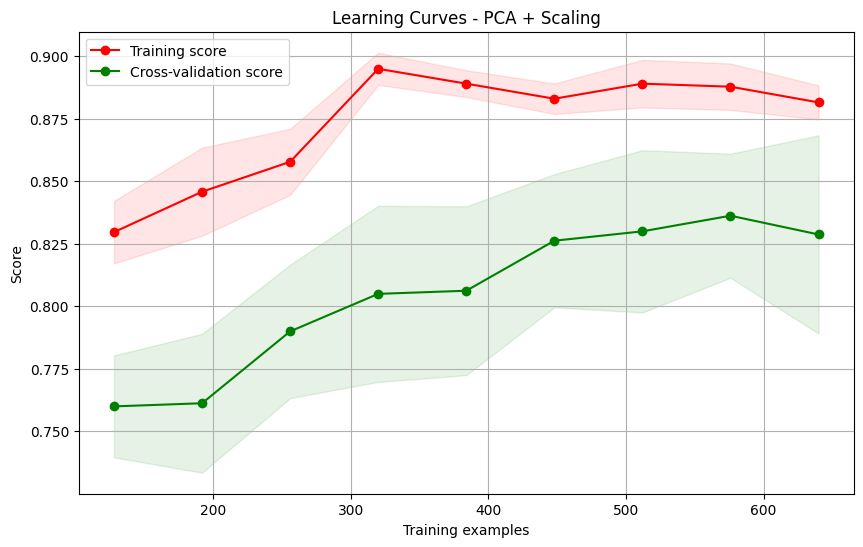


Grid Search Results for PCA + Scaling:


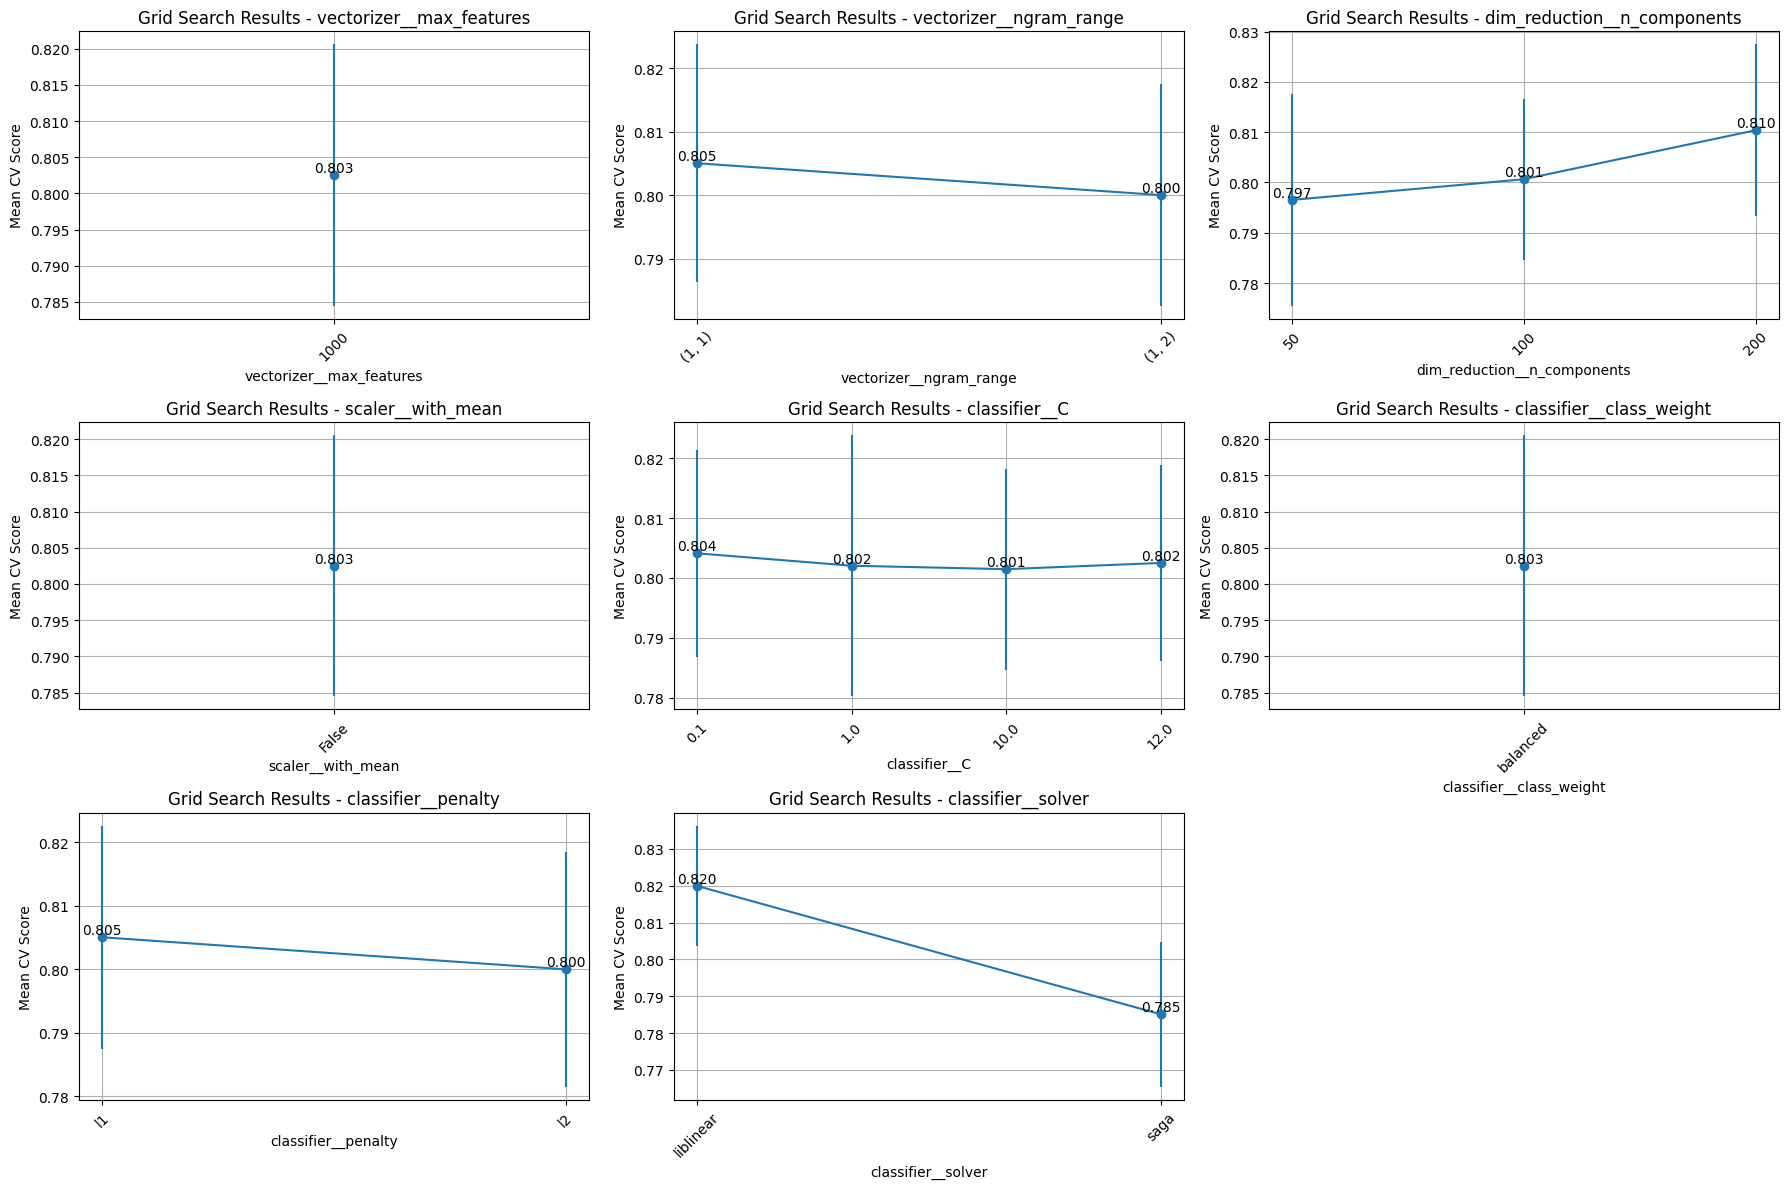


Top Features for PCA + Scaling:
Could not plot feature importance for PCA + Scaling: local variable 'importances' referenced before assignment

Class-specific Features for PCA + Scaling:


In [12]:
# Compare models
results_three = compare_models_with_grid_search(X_train_three, X_test_three, y_train_three, y_test_three, classes="3")

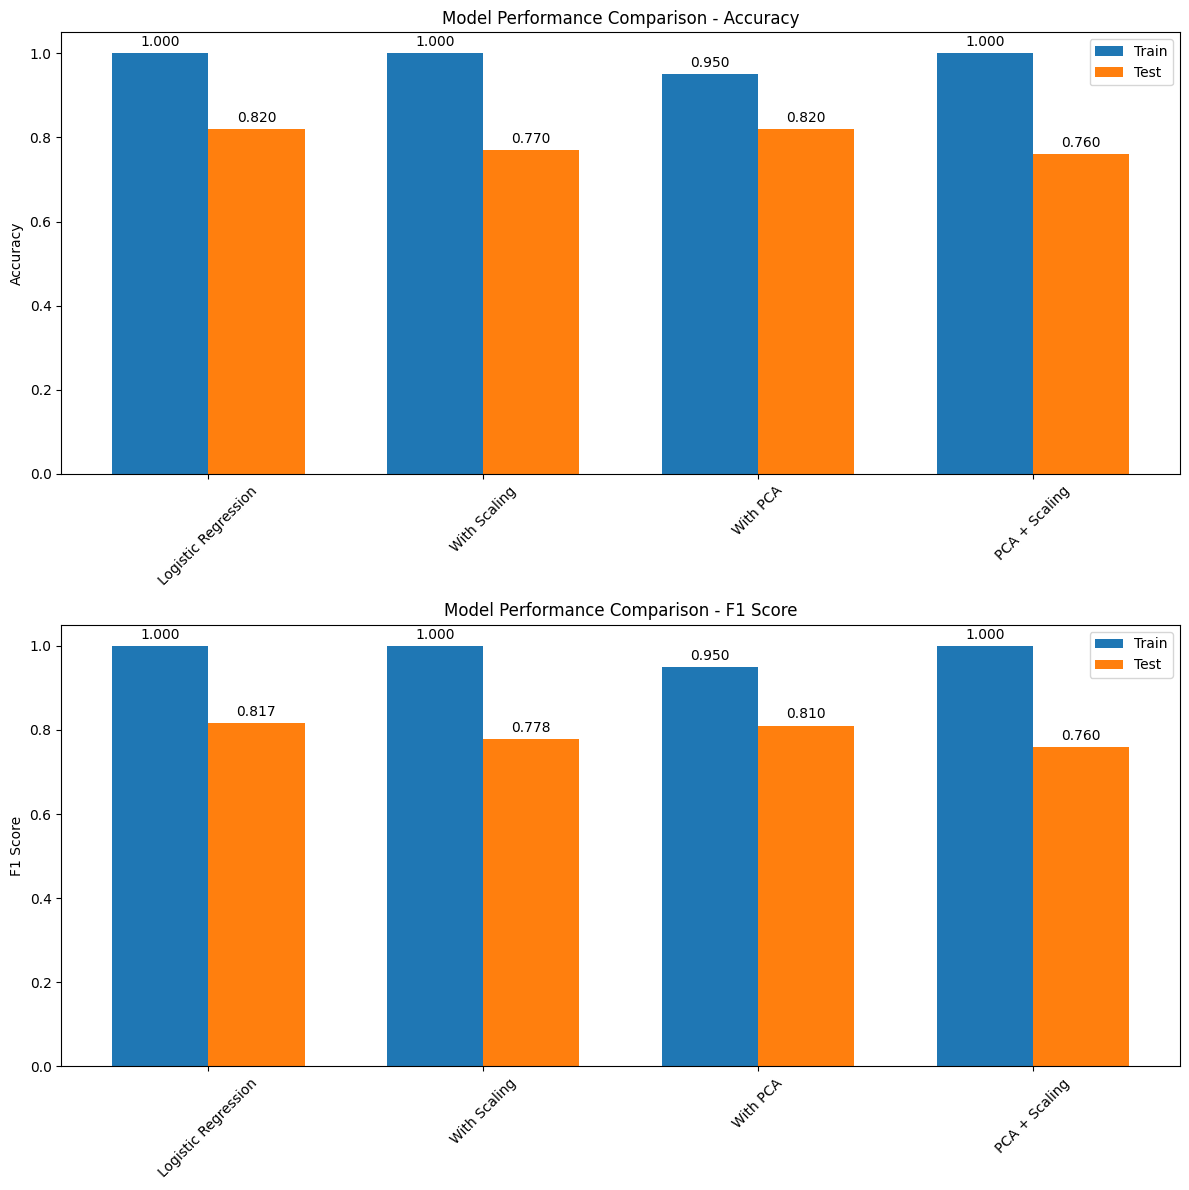

In [9]:
# Plot comparison
plot_model_comparison(results_three)

# SVM y CatBoost para clasificación de reviews de TripAdvisor

## Definiciones

In [ ]:
random_state = 42
max_iter = 20000
# Etapas del pipeline para distintos modelos
pipeline_steps = {
    "linear_svc" : [
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))),
        ("scaler", MaxAbsScaler()),
        ("classifier", OneVsOneClassifier(LinearSVC(class_weight="balanced", max_iter=max_iter, random_state=random_state)))
    ],
    "svc_linear": [
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2), max_features=10000)),
        ("scaler", MaxAbsScaler()),
        ("classifier", SVC(kernel="linear", class_weight="balanced", decision_function_shape="ovo", probability = True, max_iter=max_iter, random_state=random_state))
    ],
    "svc_rbf": [
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))),
        ("dim_reduction", TruncatedSVD(random_state=random_state)),
        ("scaler", MinMaxScaler()),
        ("classifier", SVC(kernel="rbf", class_weight="balanced", decision_function_shape="ovo", probability = True, max_iter=max_iter, random_state=random_state))
    ],
    "catboost": [
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))),
        ("dim_reduction", TruncatedSVD(random_state=random_state)),
        ("scaler", MinMaxScaler()),
        ("classifier", CatBoostClassifier(learning_rate= 0.02, task_type="GPU", random_state=random_state))
    ],
}

## Datos para 5 clases

### Instanciación de modelos con los mejores parámetros encontrados y evalucación para 5 clases

In [2]:
models = ["linear_svc_5clases", "svc_linear_5clases", "svc_rbf_5clases", "catboost_5clases", "ensemble_hard_5clases", "ensemble_soft_5clases"]

##### LinearSVC (liblinear) para 5 clases

In [4]:
model_config = "linear_svc"
optuna_db = create_db(model_config)
pipeline_linear_svc = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_linear_svc.fit(X_train, y_train)

y_train_pred = pipeline_linear_svc.predict(X_train)
y_test_pred = pipeline_linear_svc.predict(X_test)

cm_test_linear_svc, report_test_linear_svc = test_scoring(model_config, models[0], y_train, y_train_pred, y_test, y_test_pred)

[I 2024-12-10 18:55:28,734] Using an existing study with name 'linear_svc' instead of creating a new one.


{'C': 0.015}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsOneClassifier(estimator=LinearSVC(C=0.015,
                                                        class_weight='balanced',
                                                        max_iter=20000,
                                                        random_state=42)))])>

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 834,  815,  882, 1578, 2044], dtype=int64))

Score for linear_svc_5clases
          Clase  precision    recall  f1-score  support  accuracy      Modelo
0             1   0.830935  0.838983  0.834940    826.0       NaN  linear_svc
1             2   0.722699  0.628602  0.672374    937.0       NaN  linear_svc
2             3   0.464853  0.537353  0.498480    763.0       NaN  linear_svc
3             4   0.520913  0.544011  0.532211   1511.0       NaN  linear_svc
4             5   0.755871  0.730151  0.742788   2116.0       NaN  linear_svc
5      accuracy        NaN       NaN       NaN      NaN  0.659678  linear_svc
6     macro avg   0.659054  0.655820  0.656159   6153.0       NaN  linear_svc
7  weighted avg   0.667110  0.659678  0.662429   6153.0       NaN  linear_svc


##### SVC kernel linear (LibSVM) para 5 clases

[I 2024-12-10 18:55:32,537] Using an existing study with name 'svc_linear' instead of creating a new one.


{'C': 0.07}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 SVC(C=0.07, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     max_iter=20000, probability=True, random_state=42))])>

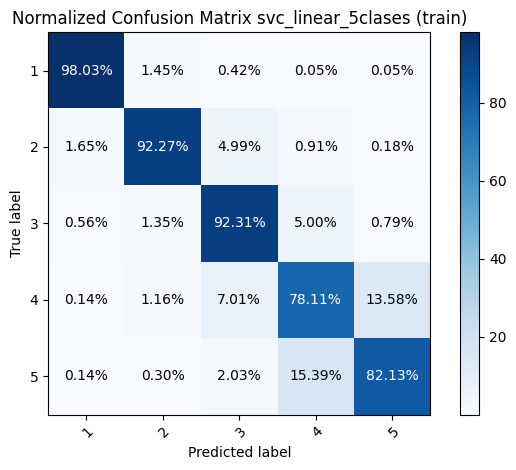

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 884,  851,  896, 1588, 1934], dtype=int64))

Score for svc_linear_5clases
          Clase  precision    recall  f1-score  support  accuracy      Modelo
0             1   0.781674  0.836562  0.808187    826.0       NaN  svc_linear
1             2   0.692127  0.628602  0.658837    937.0       NaN  svc_linear
2             3   0.454241  0.533421  0.490657    763.0       NaN  svc_linear
3             4   0.517632  0.544011  0.530494   1511.0       NaN  svc_linear
4             5   0.771458  0.705104  0.736790   2116.0       NaN  svc_linear
5      accuracy        NaN       NaN       NaN      NaN  0.650252  svc_linear
6     macro avg   0.643427  0.649540  0.644993   6153.0       NaN  svc_linear
7  weighted avg   0.659080  0.650252  0.653322   6153.0       NaN  svc_linear


In [5]:
model_config = "svc_linear"
optuna_db = create_db(model_config)
pipeline_svc_linear = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_svc_linear.fit(X_train, y_train)

y_train_pred = pipeline_svc_linear.predict(X_train)
y_test_pred = pipeline_svc_linear.predict(X_test)

cm_test_linear_svc, report_test_svc_linear = test_scoring(model_config, models[1], y_train, y_train_pred, y_test, y_test_pred)

##### SVC kernel rbf (LibSVM) para 5 clases

[I 2024-12-10 19:05:03,091] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

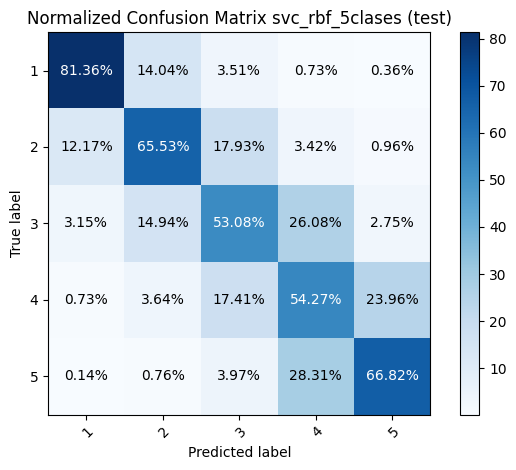

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 824,  915,  949, 1656, 1809], dtype=int64))

Score for svc_rbf_5clases
          Clase  precision    recall  f1-score  support  accuracy   Modelo
0             1   0.815534  0.813559  0.814545    826.0       NaN  svc_rbf
1             2   0.671038  0.655283  0.663067    937.0       NaN  svc_rbf
2             3   0.426765  0.530799  0.473131    763.0       NaN  svc_rbf
3             4   0.495169  0.542687  0.517840   1511.0       NaN  svc_rbf
4             5   0.781647  0.668242  0.720510   2116.0       NaN  svc_rbf
5      accuracy        NaN       NaN       NaN      NaN    0.6379  svc_rbf
6     macro avg   0.638031  0.642114  0.637819   6153.0       NaN  svc_rbf
7  weighted avg   0.654995  0.637900  0.643940   6153.0       NaN  svc_rbf


In [6]:
model_config = "svc_rbf"
optuna_db = create_db(model_config)
pipeline_svc_rbf = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_svc_rbf.fit(X_train, y_train)

y_train_pred = pipeline_svc_rbf.predict(X_train)
y_test_pred = pipeline_svc_rbf.predict(X_test)

cm_test_svc_rbf, report_test_svc_rbf = test_scoring(model_config, models[2], y_train, y_train_pred, y_test, y_test_pred)

##### Catboost para 5 clases (GPU)

In [7]:
model_config = "catboost"
optuna_db = create_db(model_config)
pipeline_catboost = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_catboost.fit(X_train, y_train)

y_train_pred = pipeline_catboost.predict(X_train)
y_test_pred = pipeline_catboost.predict(X_test)

cm_test_catboost, report_test_catboost = test_scoring(model_config, models[3], y_train, y_train_pred, y_test, y_test_pred)

[I 2024-12-10 19:14:46,859] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1250, 'iterations': 2500, 'depth': 8}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1250, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000267DE0ADA90>)])>

0:	learn: 1.5820738	total: 35.8ms	remaining: 35.7s
1:	learn: 1.5567326	total: 55.8ms	remaining: 27.9s
2:	learn: 1.5330272	total: 74.8ms	remaining: 24.9s
3:	learn: 1.5107473	total: 94.9ms	remaining: 23.6s
4:	learn: 1.4899610	total: 114ms	remaining: 22.7s
5:	learn: 1.4700568	total: 133ms	remaining: 22s
6:	learn: 1.4514388	total: 151ms	remaining: 21.4s
7:	learn: 1.4338098	total: 170ms	remaining: 21s
8:	learn: 1.4168835	total: 188ms	remaining: 20.7s
9:	learn: 1.4008981	total: 207ms	remaining: 20.5s
10:	learn: 1.3857640	total: 226ms	remaining: 20.3s
11:	learn: 1.3710748	total: 245ms	remaining: 20.1s
12:	learn: 1.3566278	total: 262ms	remaining: 19.9s
13:	learn: 1.3432410	total: 281ms	remaining: 19.8s
14:	learn: 1.3305062	total: 300ms	remaining: 19.7s
15:	learn: 1.3181503	total: 318ms	remaining: 19.5s
16:	learn: 1.3060758	total: 336ms	remaining: 19.4s
17:	learn: 1.2945261	total: 356ms	remaining: 19.4s
18:	learn: 1.2835108	total: 374ms	remaining: 19.3s
19:	learn: 1.2727807	total: 393ms	remaini

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 879,  860,  444, 1479, 2491], dtype=int64))

Score for catboost_5clases
          Clase  precision    recall  f1-score  support  accuracy    Modelo
0             1   0.778157  0.828087  0.802346    826.0       NaN  catboost
1             2   0.674419  0.618997  0.645520    937.0       NaN  catboost
2             3   0.581081  0.338139  0.427506    763.0       NaN  catboost
3             4   0.500338  0.489742  0.494983   1511.0       NaN  catboost
4             5   0.692092  0.814745  0.748426   2116.0       NaN  catboost
5      accuracy        NaN       NaN       NaN      NaN  0.647814  catboost
6     macro avg   0.645217  0.617942  0.623756   6153.0       NaN  catboost
7  weighted avg   0.640099  0.647814  0.637960   6153.0       NaN  catboost


### Ensemble

#### Hard voting classifier

[I 2024-12-10 20:55:06,344] Using an existing study with name 'linear_svc' instead of creating a new one.


{'C': 0.015}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsOneClassifier(estimator=LinearSVC(C=0.015,
                                                        class_weight='balanced',
                                                        max_iter=20000,
                                                        random_state=42)))])>

[I 2024-12-10 20:55:06,380] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

[I 2024-12-10 20:55:06,458] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1250, 'iterations': 2500, 'depth': 8}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1250, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024ADAC0>)])>

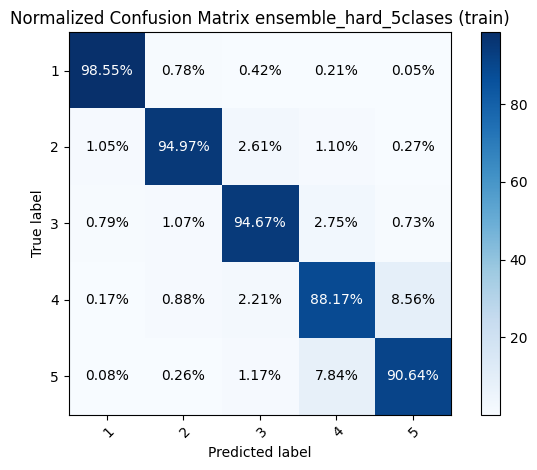

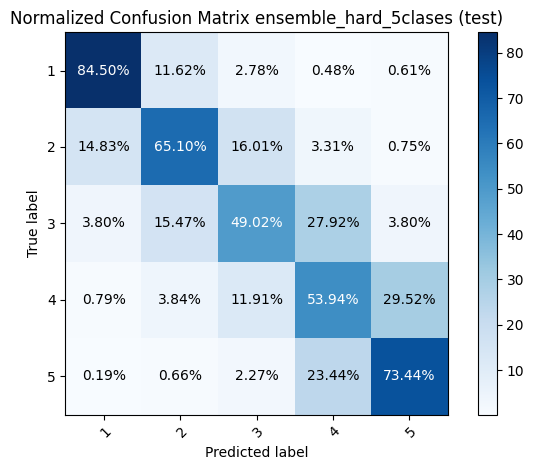

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 882,  896,  775, 1559, 2041], dtype=int64))

Score for ensemble_hard_5clases
          Clase  precision    recall  f1-score  support  accuracy  \
0             1   0.791383  0.845036  0.817330    826.0       NaN   
1             2   0.680804  0.651014  0.665576    937.0       NaN   
2             3   0.482581  0.490170  0.486346    763.0       NaN   
3             4   0.522771  0.539378  0.530945   1511.0       NaN   
4             5   0.761391  0.734405  0.747655   2116.0       NaN   
5      accuracy        NaN       NaN       NaN      NaN  0.658378   
6     macro avg   0.647786  0.652001  0.649570   6153.0       NaN   
7  weighted avg   0.659973  0.658378  0.658888   6153.0       NaN   

                  Modelo  
0  votingclassifier_hard  
1  votingclassifier_hard  
2  votingclassifier_hard  
3  votingclassifier_hard  
4  votingclassifier_hard  
5  votingclassifier_hard  
6  votingclassifier_hard  
7  votingclassifier_hard  


In [4]:
model_config = "linear_svc"
optuna_db = create_db(model_config)
linear_svc = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "svc_rbf"
optuna_db = create_db(model_config)
svc = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "catboost"
optuna_db = create_db(model_config)
catboost = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
catboost = CatBoostWrapper(catboost)

classifiers = [('LinearSVC', linear_svc),
               ('SVC RBF', svc),
               ('Catboost', catboost),
              ]

vc = VotingClassifier(estimators=classifiers, voting="hard", verbose=True, n_jobs=-1)
vc.fit(X_train, y_train)

y_train_pred = vc.predict(X_train)
y_test_pred = vc.predict(X_test)

cm_test_ensemble_hard, report_test_ensemble_hard = test_scoring("votingclassifier_hard", models[4], y_train, y_train_pred, y_test, y_test_pred)

#### Soft voting classifier

[I 2024-12-10 21:05:30,134] Using an existing study with name 'svc_linear' instead of creating a new one.


{'C': 0.07}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 SVC(C=0.07, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     max_iter=20000, probability=True, random_state=42))])>

[I 2024-12-10 21:05:30,162] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

[I 2024-12-10 21:05:30,191] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1250, 'iterations': 2500, 'depth': 8}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1250, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024ADAC0>)])>

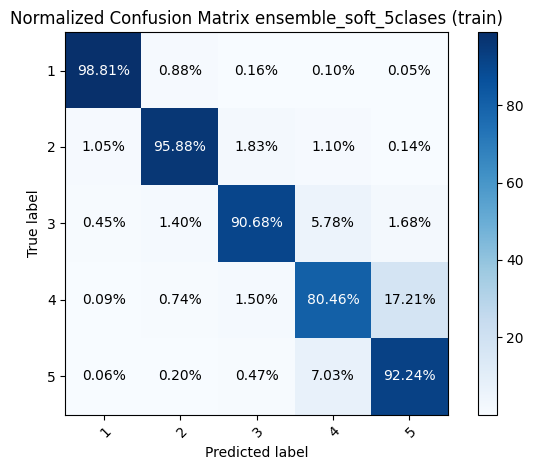

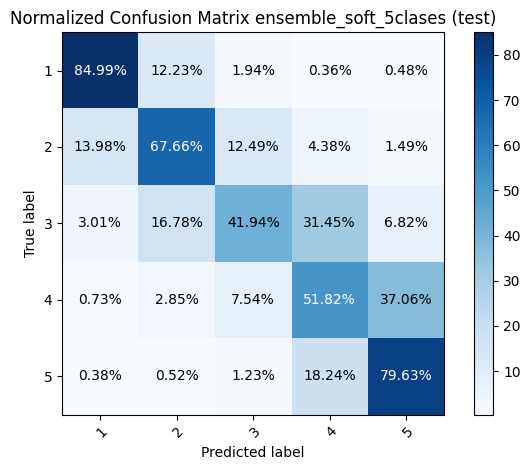

'Y Test'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 826,  937,  763, 1511, 2116], dtype=int64))

'Y Test Predictions'

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 875,  917,  593, 1453, 2315], dtype=int64))

Score for ensemble_soft_5clases
          Clase  precision    recall  f1-score  support  accuracy  \
0             1   0.802286  0.849879  0.825397    826.0       NaN   
1             2   0.691385  0.676628  0.683927    937.0       NaN   
2             3   0.539629  0.419397  0.471976    763.0       NaN   
3             4   0.538885  0.518200  0.528340   1511.0       NaN   
4             5   0.727862  0.796314  0.760551   2116.0       NaN   
5      accuracy        NaN       NaN       NaN      NaN  0.670242   
6     macro avg   0.660009  0.652083  0.654038   6153.0       NaN   
7  weighted avg   0.662549  0.670242  0.664778   6153.0       NaN   

                  Modelo  
0  votingclassifier_soft  
1  votingclassifier_soft  
2  votingclassifier_soft  
3  votingclassifier_soft  
4  votingclassifier_soft  
5  votingclassifier_soft  
6  votingclassifier_soft  
7  votingclassifier_soft  


In [5]:
model_config = "svc_linear"
optuna_db = create_db(model_config)
svc_linear = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "svc_rbf"
optuna_db = create_db(model_config)
svc = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "catboost"
optuna_db = create_db(model_config)
catboost = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
catboost = CatBoostWrapper(catboost)

classifiers = [('SVC', svc),
               ('SVC Linear', svc_linear),
               ('Catboost', catboost)
              ]

vc = VotingClassifier(estimators=classifiers, voting="soft", verbose=True, n_jobs=-1)
vc.fit(X_train, y_train)

y_train_pred = vc.predict(X_train)
y_test_pred = vc.predict(X_test)

cm_test_ensemble_soft, report_test_ensemble_soft = test_scoring("votingclassifier_soft", models[5], y_train, y_train_pred, y_test, y_test_pred)

### Comparación de modelos

Clase  precision    recall  f1-score  support  accuracy  \
0              1   0.830935  0.838983  0.834940    826.0       NaN   
1              2   0.722699  0.628602  0.672374    937.0       NaN   
2              3   0.464853  0.537353  0.498480    763.0       NaN   
3              4   0.520913  0.544011  0.532211   1511.0       NaN   
4              5   0.755871  0.730151  0.742788   2116.0       NaN   
5       accuracy        NaN       NaN       NaN      NaN  0.659678   
6      macro avg   0.659054  0.655820  0.656159   6153.0       NaN   
7   weighted avg   0.667110  0.659678  0.662429   6153.0       NaN   
8              1   0.781674  0.836562  0.808187    826.0       NaN   
9              2   0.692127  0.628602  0.658837    937.0       NaN   
10             3   0.454241  0.533421  0.490657    763.0       NaN   
11             4   0.517632  0.544011  0.530494   1511.0       NaN   
12             5   0.771458  0.705104  0.736790   2116.0       NaN   
13      accuracy        NaN       NaN       NaN      NaN  0.650252   
14     macro avg   0.643427  0.649540  0.644993   6153.0       NaN   
15  weighted avg   0.659080  0.650252  0.653322   6153.0       NaN   
16             1   0.815534  0.813559  0.814545    826.0       NaN   
17             2   0.671038  0.655283  0.663067    937.0       NaN   
18             3   0.426765  0.530799  0.473131    763.0       NaN   
19             4   0.495169  0.542687  0.517840   1511.0       NaN   
20             5   0.781647  0.668242  0.720510   2116.0       NaN   
21      accuracy        NaN       NaN       NaN      NaN  0.637900   
22     macro avg   0.638031  0.642114  0.637819   6153.0       NaN   
23  weighted avg   0.654995  0.637900  0.643940   6153.0       NaN   
24             1   0.778157  0.828087  0.802346    826.0       NaN   
25             2   0.674419  0.618997  0.645520    937.0       NaN   
26             3   0.581081  0.338139  0.427506    763.0       NaN   
27             4   0.500338  0.489742  0.494983   1511.0       NaN   
28             5   0.692092  0.814745  0.748426   2116.0       NaN   
29      accuracy        NaN       NaN       NaN      NaN  0.647814   
30     macro avg   0.645217  0.617942  0.623756   6153.0       NaN   
31  weighted avg   0.640099  0.647814  0.637960   6153.0       NaN   
32             1   0.791383  0.845036  0.817330    826.0       NaN   
33             2   0.680804  0.651014  0.665576    937.0       NaN   
34             3   0.482581  0.490170  0.486346    763.0       NaN   
35             4   0.522771  0.539378  0.530945   1511.0       NaN   
36             5   0.761391  0.734405  0.747655   2116.0       NaN   
37      accuracy        NaN       NaN       NaN      NaN  0.658378   
38     macro avg   0.647786  0.652001  0.649570   6153.0       NaN   
39  weighted avg   0.659973  0.658378  0.658888   6153.0       NaN   
40             1   0.802286  0.849879  0.825397    826.0       NaN   
41             2   0.691385  0.676628  0.683927    937.0       NaN   
42             3   0.539629  0.419397  0.471976    763.0       NaN   
43             4   0.538885  0.518200  0.528340   1511.0       NaN   
44             5   0.727862  0.796314  0.760551   2116.0       NaN   
45      accuracy        NaN       NaN       NaN      NaN  0.670242   
46     macro avg   0.660009  0.652083  0.654038   6153.0       NaN   
47  weighted avg   0.662549  0.670242  0.664778   6153.0       NaN   

                   Modelo  
0              linear_svc  
1              linear_svc  
2              linear_svc  
3              linear_svc  
4              linear_svc  
5              linear_svc  
6              linear_svc  
7              linear_svc  
8              svc_linear  
9              svc_linear  
10             svc_linear  
11             svc_linear  
12             svc_linear  
13             svc_linear  
14             svc_linear  
15             svc_linear  
16                svc_rbf  
17                svc_rbf  
18                svc_rbf  
19                sv

c:\Users\Pablo\IA-repos\AM1-TP\utils.py:821: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Modelo")


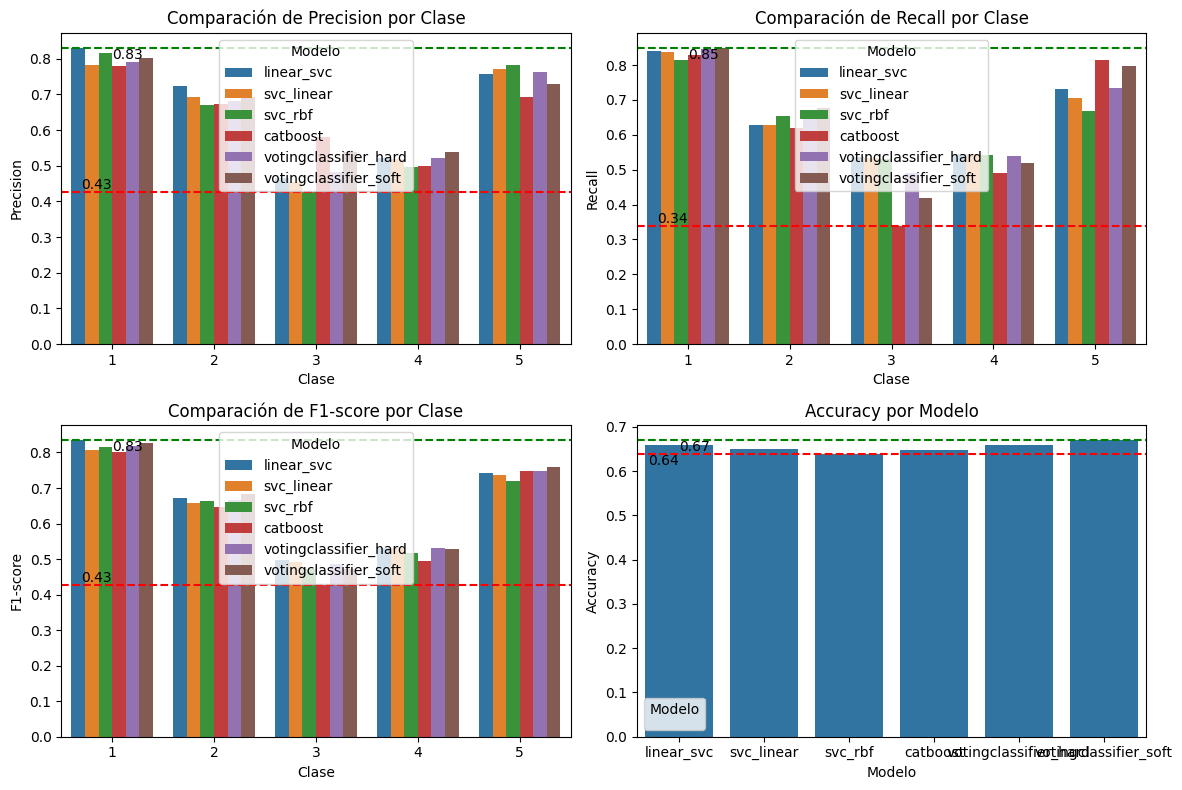

<Figure size 640x480 with 0 Axes>


Métricas ponderadas por modelo:
                       precision    recall  f1-score
Modelo                                              
linear_svc              0.667110  0.659678  0.662429
svc_linear              0.659080  0.650252  0.653322
svc_rbf                 0.654995  0.637900  0.643940
catboost                0.640099  0.647814  0.637960
votingclassifier_hard   0.659973  0.658378  0.658888
votingclassifier_soft   0.662549  0.670242  0.664778


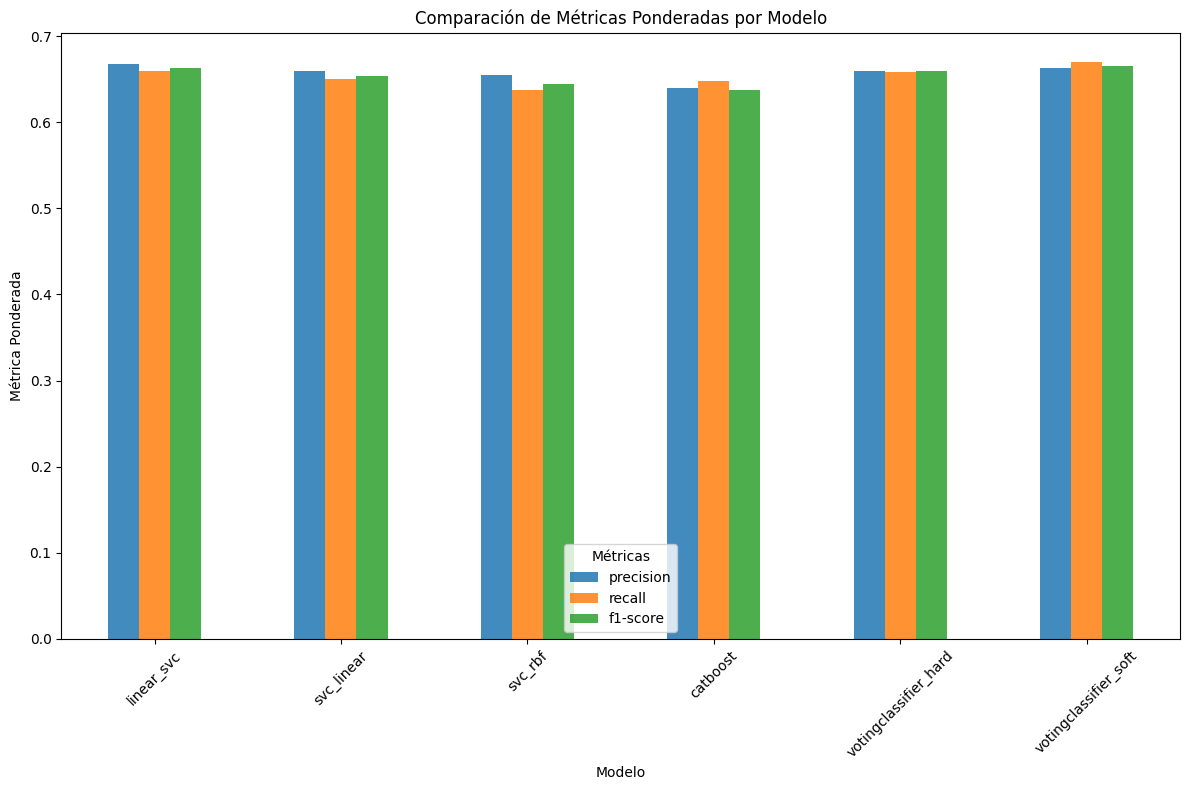


El mejor modelo es votingclassifier_soft con un F1-Score ponderado de 0.6648.


In [6]:
try:
    cms = [cm_test_linear_svc, cm_test_linear_svc, cm_test_svc_rbf, cm_test_catboost]
except:
    cms = None

compare_models (models, cms)

## Datos para 3 clases

### Instanciación de modelos con los mejores parámetros encontrados y evalucación para 3 clases

In [3]:
models = ["linear_svc_3clases", "svc_linear_3clases", "svc_rbf_3clases", "catboost_3clases", "ensemble_hard_3clases", "ensemble_soft_3clases", "weighted_ensemble_3clases"]

##### LinearSVC (liblinear) para 3 clases

[I 2024-12-10 21:40:41,780] Using an existing study with name 'linear_svc' instead of creating a new one.


{'C': 0.075}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsOneClassifier(estimator=LinearSVC(C=0.075,
                                                        class_weight='balanced',
                                                        max_iter=20000,
                                                        random_state=42)))])>

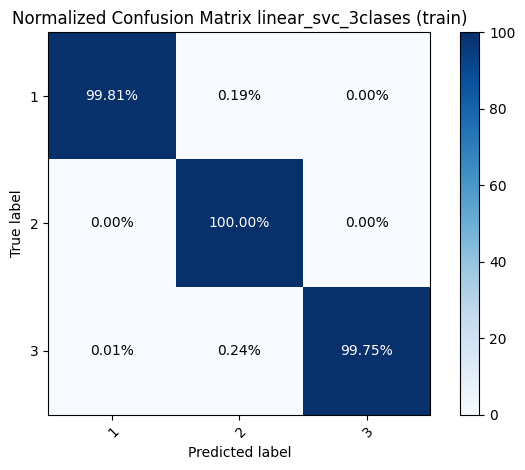

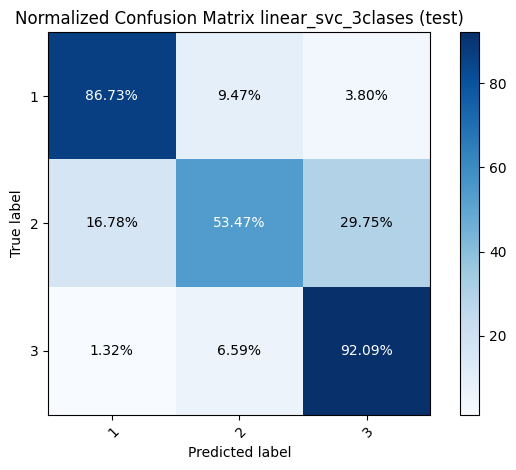

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1705,  814, 3634], dtype=int64))

Score for linear_svc_3clases
          Clase  precision    recall  f1-score  support  accuracy      Modelo
0             0   0.896774  0.867272  0.881776   1763.0       NaN  linear_svc
1             1   0.501229  0.534731  0.517438    763.0       NaN  linear_svc
2             2   0.919097  0.920871  0.919983   3627.0       NaN  linear_svc
3      accuracy        NaN       NaN       NaN      NaN   0.85763  linear_svc
4     macro avg   0.772367  0.774291  0.773066   6153.0       NaN  linear_svc
5  weighted avg   0.860884  0.857630  0.859119   6153.0       NaN  linear_svc


In [ ]:
model_config = "linear_svc"
optuna_db = create_db(model_config, 3)
pipeline_linear_svc_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_linear_svc_3.fit(X_train, y_train)

y_train_pred = pipeline_linear_svc_3.predict(X_train)
y_test_pred = pipeline_linear_svc_3.predict(X_test)

cm_test_linear_svc, report_test_linear_svc = test_scoring(model_config, models[0], y_train, y_train_pred, y_test, y_test_pred)

##### SVC kernel linear (LibSVM) para 3 clases

[I 2024-12-10 21:40:57,292] Using an existing study with name 'svc_linear' instead of creating a new one.


{'C': 0.22}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 SVC(C=0.22, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     max_iter=20000, probability=True, random_state=42))])>

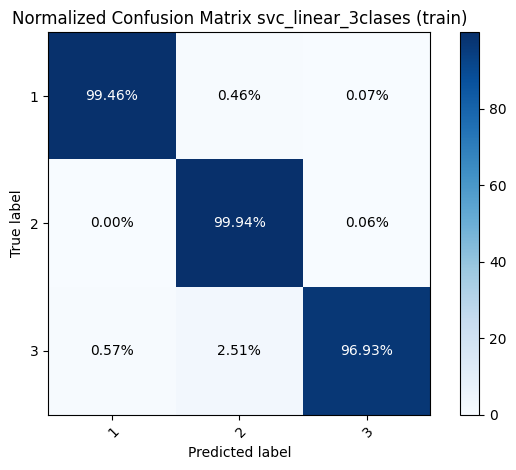

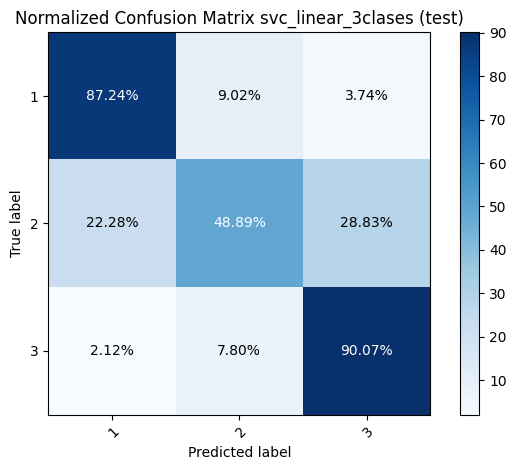

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1785,  815, 3553], dtype=int64))

Score for svc_linear_3clases
          Clase  precision    recall  f1-score  support  accuracy      Modelo
0             0   0.861625  0.872377  0.866967   1763.0       NaN  svc_linear
1             1   0.457669  0.488860  0.472750    763.0       NaN  svc_linear
2             2   0.919505  0.900744  0.910028   3627.0       NaN  svc_linear
3      accuracy        NaN       NaN       NaN      NaN  0.841541  svc_linear
4     macro avg   0.746266  0.753994  0.749915   6153.0       NaN  svc_linear
5  weighted avg   0.845651  0.841541  0.843465   6153.0       NaN  svc_linear


In [9]:
model_config = "svc_linear"
optuna_db = create_db(model_config, 3)
pipeline_svc_linear_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_svc_linear_3.fit(X_train, y_train)

y_train_pred = pipeline_svc_linear_3.predict(X_train)
y_test_pred = pipeline_svc_linear_3.predict(X_test)

cm_test_linear_svc, report_test_svc_linear = test_scoring(model_config, models[1], y_train, y_train_pred, y_test, y_test_pred)

##### SVC kernel rbf (LibSVM) para 3 clases

[I 2024-12-10 21:46:28,293] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

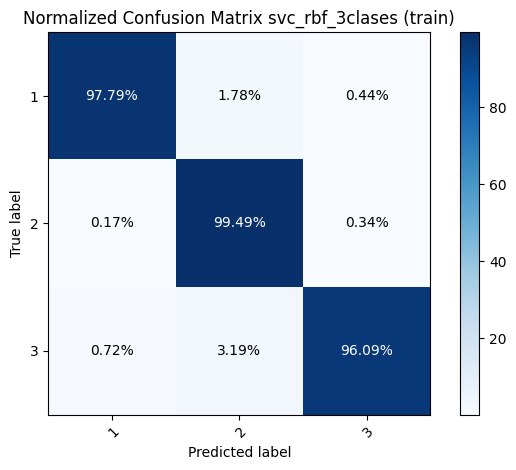

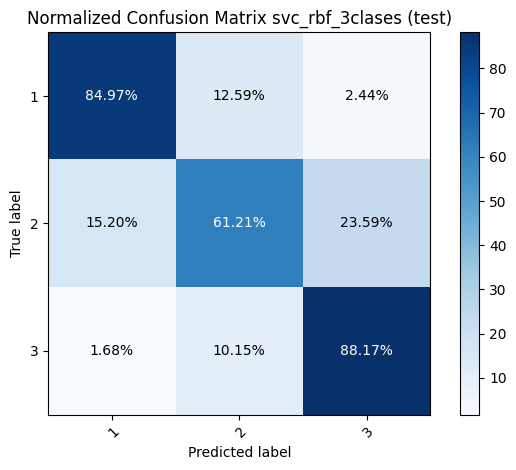

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1675, 1057, 3421], dtype=int64))

Score for svc_rbf_3clases
          Clase  precision    recall  f1-score  support  accuracy   Modelo
0             0   0.894328  0.849688  0.871437   1763.0       NaN  svc_rbf
1             1   0.441816  0.612058  0.513187    763.0       NaN  svc_rbf
2             2   0.934814  0.881720  0.907491   3627.0       NaN  svc_rbf
3      accuracy        NaN       NaN       NaN      NaN  0.839103  svc_rbf
4     macro avg   0.756986  0.781155  0.764038   6153.0       NaN  svc_rbf
5  weighted avg   0.862080  0.839103  0.848265   6153.0       NaN  svc_rbf


In [10]:
model_config = "svc_rbf"
optuna_db = create_db(model_config, 3)
pipeline_svc_rbf_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_svc_rbf_3.fit(X_train, y_train)

y_train_pred = pipeline_svc_rbf_3.predict(X_train)
y_test_pred = pipeline_svc_rbf_3.predict(X_test)

cm_test_svc_rbf, report_test_svc_rbf = test_scoring(model_config, models[2], y_train, y_train_pred, y_test, y_test_pred)

##### Catboost para 3 clases (GPU)

[I 2024-12-10 21:53:36,628] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1500, 'iterations': 2500, 'depth': 6}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1500, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024ADAC0>)])>

0:	learn: 1.0757940	total: 32.7ms	remaining: 32.7s
1:	learn: 1.0541934	total: 47ms	remaining: 23.5s
2:	learn: 1.0337179	total: 61.3ms	remaining: 20.4s
3:	learn: 1.0142124	total: 76.1ms	remaining: 18.9s
4:	learn: 0.9956723	total: 90.3ms	remaining: 18s
5:	learn: 0.9778460	total: 104ms	remaining: 17.3s
6:	learn: 0.9608965	total: 119ms	remaining: 16.8s
7:	learn: 0.9447389	total: 132ms	remaining: 16.4s
8:	learn: 0.9291175	total: 146ms	remaining: 16.1s
9:	learn: 0.9141772	total: 163ms	remaining: 16.1s
10:	learn: 0.8999726	total: 178ms	remaining: 16s
11:	learn: 0.8861891	total: 192ms	remaining: 15.8s
12:	learn: 0.8729367	total: 206ms	remaining: 15.6s
13:	learn: 0.8602592	total: 221ms	remaining: 15.6s
14:	learn: 0.8481946	total: 236ms	remaining: 15.5s
15:	learn: 0.8365364	total: 250ms	remaining: 15.4s
16:	learn: 0.8252133	total: 266ms	remaining: 15.4s
17:	learn: 0.8142784	total: 280ms	remaining: 15.3s
18:	learn: 0.8037890	total: 295ms	remaining: 15.2s
19:	learn: 0.7937178	total: 309ms	remainin

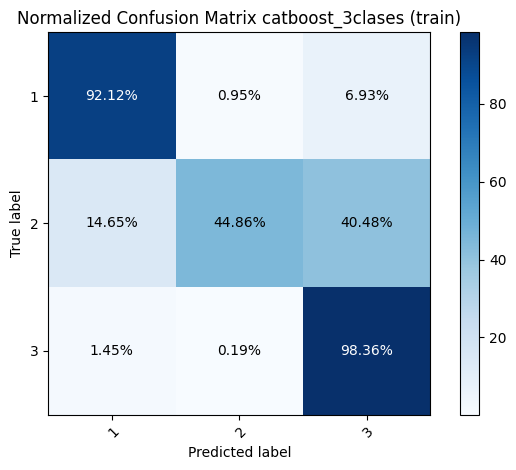

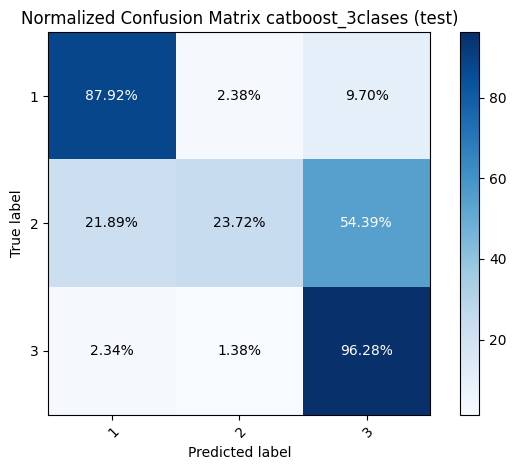

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1802,  273, 4078], dtype=int64))

Score for catboost_3clases
          Clase  precision    recall  f1-score  support  accuracy    Modelo
0             0   0.860155  0.879183  0.869565   1763.0       NaN  catboost
1             1   0.663004  0.237221  0.349421    763.0       NaN  catboost
2             2   0.856302  0.962779  0.906424   3627.0       NaN  catboost
3      accuracy        NaN       NaN       NaN      NaN  0.848854  catboost
4     macro avg   0.793154  0.693061  0.708470   6153.0       NaN  catboost
5  weighted avg   0.833436  0.848854  0.826792   6153.0       NaN  catboost


In [ ]:
model_config = "catboost"
optuna_db = create_db(model_config, 3)
pipeline_catboost_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
pipeline_catboost_3.fit(X_train, y_train)

y_train_pred = pipeline_catboost_3.predict(X_train)
y_test_pred = pipeline_catboost_3.predict(X_test)

cm_test_catboost, report_test_catboost = test_scoring(model_config, models[3], y_train, y_train_pred, y_test, y_test_pred)

### Ensemble

#### Hard voting classifier

[I 2024-12-10 23:08:47,812] Using an existing study with name 'linear_svc' instead of creating a new one.


{'C': 0.075}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsOneClassifier(estimator=LinearSVC(C=0.075,
                                                        class_weight='balanced',
                                                        max_iter=20000,
                                                        random_state=42)))])>

[I 2024-12-10 23:08:47,842] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

[I 2024-12-10 23:08:47,882] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1500, 'iterations': 2500, 'depth': 6}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1500, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024AD970>)])>

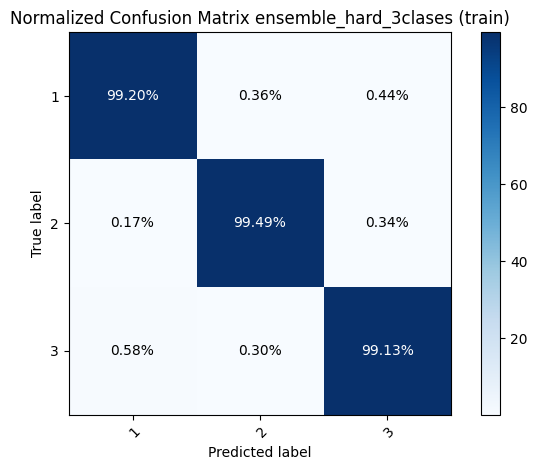

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1783,  688, 3682], dtype=int64))

Score for ensemble_hard_3clases
          Clase  precision    recall  f1-score  support  accuracy  \
0             0   0.881660  0.891662  0.886633   1763.0       NaN   
1             1   0.543605  0.490170  0.515507    763.0       NaN   
2             2   0.916078  0.929970  0.922972   3627.0       NaN   
3      accuracy        NaN       NaN       NaN      NaN  0.864456   
4     macro avg   0.780448  0.770601  0.775037   6153.0       NaN   
5  weighted avg   0.860028  0.864456  0.862032   6153.0       NaN   

                  Modelo  
0  votingclassifier_hard  
1  votingclassifier_hard  
2  votingclassifier_hard  
3  votingclassifier_hard  
4  votingclassifier_hard  
5  votingclassifier_hard  
CPU times: total: 24.3 s
Wall time: 7min 33s


In [19]:
%%time
model_config = "linear_svc"
optuna_db = create_db(model_config, 3)
linear_svc_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "svc_rbf"
optuna_db = create_db(model_config, 3)
svc_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "catboost"
optuna_db = create_db(model_config, 3)
catboost_3 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
catboost_3 = CatBoostWrapper(catboost_3)

classifiers = [('LinearSVC', linear_svc_3),
               ('SVC RBF', svc_3),
               ('Catboost', catboost_3),
              ]

vc = VotingClassifier(estimators=classifiers, voting="hard", verbose=True, n_jobs=-1)
vc.fit(X_train, y_train)

y_train_pred = vc.predict(X_train)
y_test_pred = vc.predict(X_test)

cm_test_ensemble_hard, report_test_ensemble_hard = test_scoring("votingclassifier_hard", models[4], y_train, y_train_pred, y_test, y_test_pred)

#### Soft voting classifier

[I 2024-12-10 23:16:20,832] Using an existing study with name 'svc_linear' instead of creating a new one.


{'C': 0.22}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 SVC(C=0.22, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     max_iter=20000, probability=True, random_state=42))])>

[I 2024-12-10 23:16:20,861] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

[I 2024-12-10 23:16:20,892] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1500, 'iterations': 2500, 'depth': 6}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1500, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024AD970>)])>

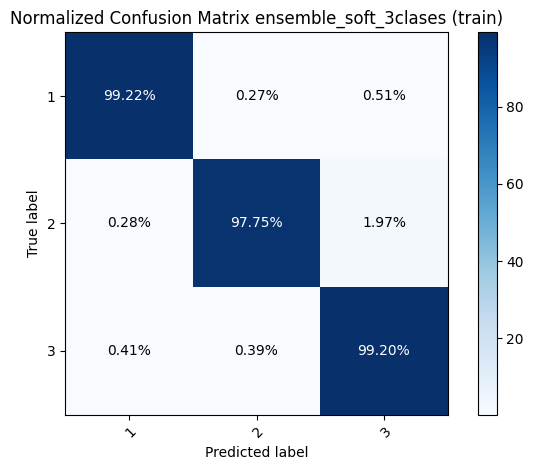

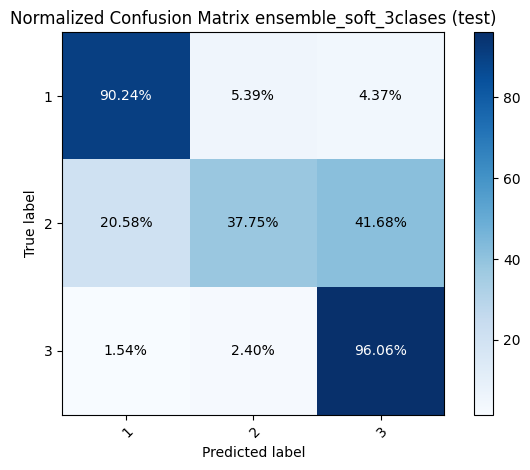

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1804,  470, 3879], dtype=int64))

Score for ensemble_soft_3clases
          Clase  precision    recall  f1-score  support  accuracy  \
0             0   0.881929  0.902439  0.892066   1763.0       NaN   
1             1   0.612766  0.377457  0.467153    763.0       NaN   
2             2   0.898170  0.960573  0.928324   3627.0       NaN   
3      accuracy        NaN       NaN       NaN      NaN  0.871607   
4     macro avg   0.797622  0.746823  0.762514   6153.0       NaN   
5  weighted avg   0.858125  0.871607  0.860748   6153.0       NaN   

                  Modelo  
0  votingclassifier_soft  
1  votingclassifier_soft  
2  votingclassifier_soft  
3  votingclassifier_soft  
4  votingclassifier_soft  
5  votingclassifier_soft  
CPU times: total: 30.8 s
Wall time: 8min 49s


In [20]:
%%time
model_config = "svc_linear"
optuna_db = create_db(model_config, 3)
svc_linear_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "svc_rbf"
optuna_db = create_db(model_config, 3)
svc_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "catboost"
optuna_db = create_db(model_config, 3)
catboost_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
catboost_32 = CatBoostWrapper(catboost_32)

classifiers = [('SVC', svc_32),
               ('SVC Linear', svc_linear_32),
               ('Catboost', catboost_32)
              ]

vc = VotingClassifier(estimators=classifiers, voting="soft", verbose=True, n_jobs=-1)
vc.fit(X_train, y_train)

y_train_pred = vc.predict(X_train)
y_test_pred = vc.predict(X_test)

cm_test_ensemble_soft, report_test_ensemble_soft = test_scoring("votingclassifier_soft", models[5], y_train, y_train_pred, y_test, y_test_pred)

### Comparación de modelos

Clase  precision    recall  f1-score  support  accuracy  \
0              0   0.896774  0.867272  0.881776   1763.0       NaN   
1              1   0.501229  0.534731  0.517438    763.0       NaN   
2              2   0.919097  0.920871  0.919983   3627.0       NaN   
3       accuracy        NaN       NaN       NaN      NaN  0.857630   
4      macro avg   0.772367  0.774291  0.773066   6153.0       NaN   
5   weighted avg   0.860884  0.857630  0.859119   6153.0       NaN   
6              0   0.861625  0.872377  0.866967   1763.0       NaN   
7              1   0.457669  0.488860  0.472750    763.0       NaN   
8              2   0.919505  0.900744  0.910028   3627.0       NaN   
9       accuracy        NaN       NaN       NaN      NaN  0.841541   
10     macro avg   0.746266  0.753994  0.749915   6153.0       NaN   
11  weighted avg   0.845651  0.841541  0.843465   6153.0       NaN   
12             0   0.894328  0.849688  0.871437   1763.0       NaN   
13             1   0.441816  0.612058  0.513187    763.0       NaN   
14             2   0.934814  0.881720  0.907491   3627.0       NaN   
15      accuracy        NaN       NaN       NaN      NaN  0.839103   
16     macro avg   0.756986  0.781155  0.764038   6153.0       NaN   
17  weighted avg   0.862080  0.839103  0.848265   6153.0       NaN   
18             0   0.860155  0.879183  0.869565   1763.0       NaN   
19             1   0.663004  0.237221  0.349421    763.0       NaN   
20             2   0.856302  0.962779  0.906424   3627.0       NaN   
21      accuracy        NaN       NaN       NaN      NaN  0.848854   
22     macro avg   0.793154  0.693061  0.708470   6153.0       NaN   
23  weighted avg   0.833436  0.848854  0.826792   6153.0       NaN   
24             0   0.881660  0.891662  0.886633   1763.0       NaN   
25             1   0.543605  0.490170  0.515507    763.0       NaN   
26             2   0.916078  0.929970  0.922972   3627.0       NaN   
27      accuracy        NaN       NaN       NaN      NaN  0.864456   
28     macro avg   0.780448  0.770601  0.775037   6153.0       NaN   
29  weighted avg   0.860028  0.864456  0.862032   6153.0       NaN   
30             0   0.881929  0.902439  0.892066   1763.0       NaN   
31             1   0.612766  0.377457  0.467153    763.0       NaN   
32             2   0.898170  0.960573  0.928324   3627.0       NaN   
33      accuracy        NaN       NaN       NaN      NaN  0.871607   
34     macro avg   0.797622  0.746823  0.762514   6153.0       NaN   
35  weighted avg   0.858125  0.871607  0.860748   6153.0       NaN   

                   Modelo  
0              linear_svc  
1              linear_svc  
2              linear_svc  
3              linear_svc  
4              linear_svc  
5              linear_svc  
6              svc_linear  
7              svc_linear  
8              svc_linear  
9              svc_linear  
10             svc_linear  
11             svc_linear  
12                svc_rbf  
13                svc_rbf  
14                svc_rbf  
15                svc_rbf  
16                svc_rbf  
17                svc_rbf  
18               catboost  
19               catboost  
20               catboost  
21               catboost  
22               catboost  
23               catboost  
24  votingclassifier_hard  
25  votingclassifier_hard  
26  votingclassifier_hard  
27  votingclassifier_hard  
28  votingclassifier_hard  
29  votingclassifier_hard  
30  votingclassifier_soft  
31  votingclassifier_soft  
32  votingclassifier_soft  
33  votingclassifier_soft  
34  votingclassifier_soft  
35  votingclassifier_soft

c:\Users\Pablo\IA-repos\AM1-TP\utils.py:821: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.ylabel("Accuracy")


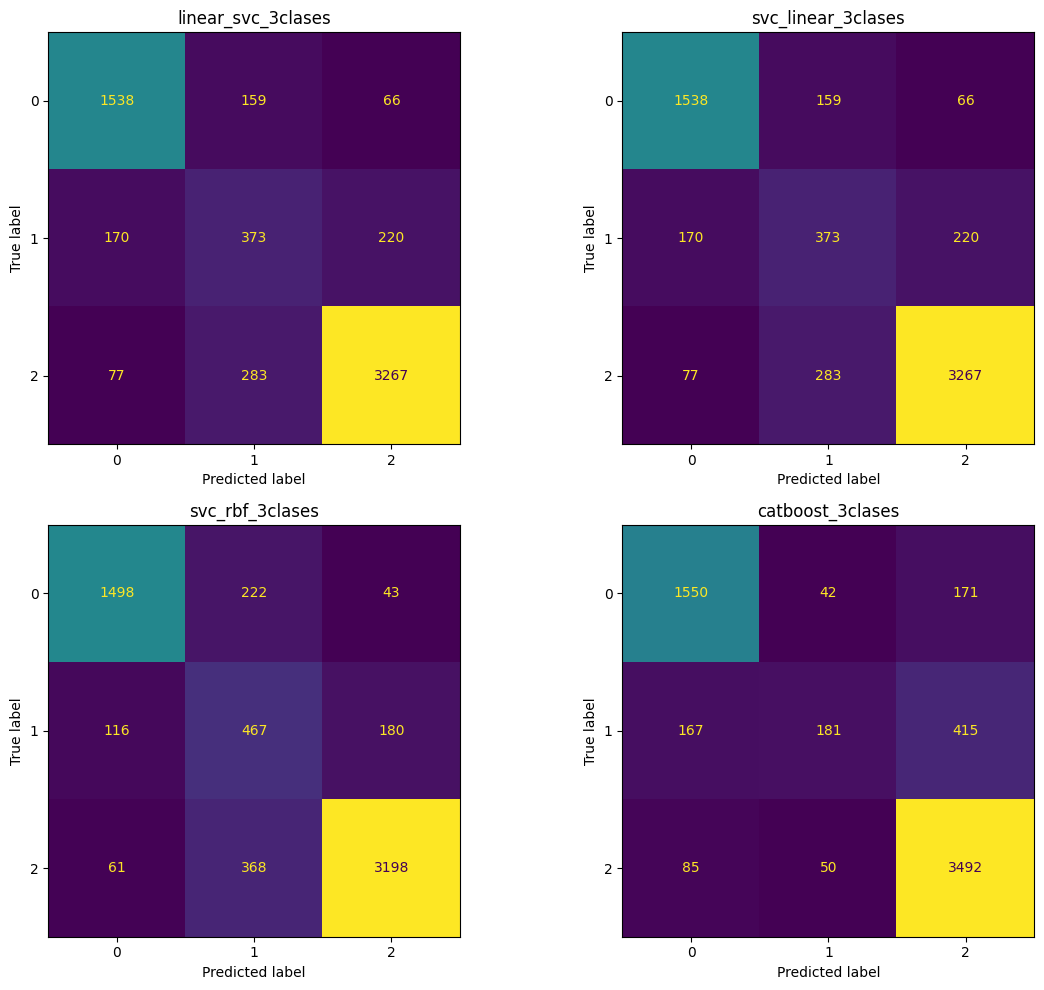


Métricas ponderadas por modelo:
                       precision    recall  f1-score
Modelo                                              
linear_svc              0.860884  0.857630  0.859119
svc_linear              0.845651  0.841541  0.843465
svc_rbf                 0.862080  0.839103  0.848265
catboost                0.833436  0.848854  0.826792
votingclassifier_hard   0.860028  0.864456  0.862032
votingclassifier_soft   0.858125  0.871607  0.860748


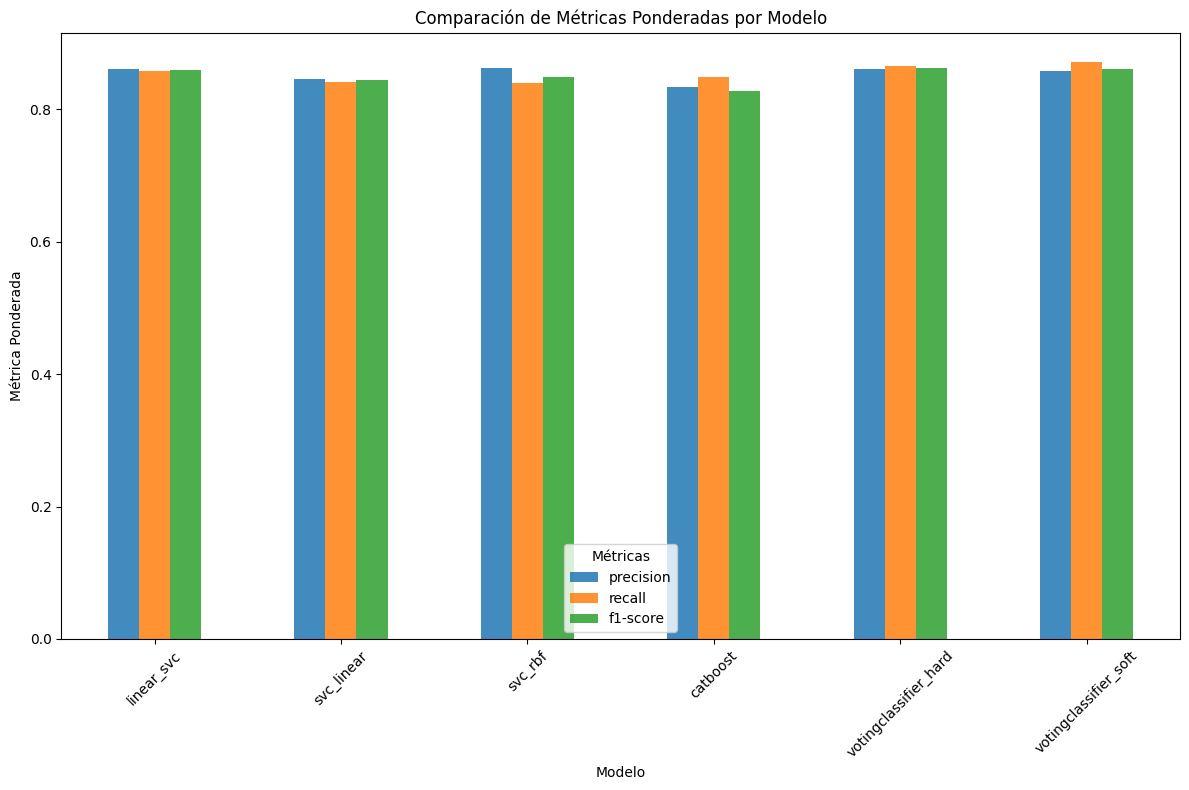


El mejor modelo es votingclassifier_hard con un F1-Score ponderado de 0.8620.


In [21]:
try:
    cms = [cm_test_linear_svc, cm_test_linear_svc, cm_test_svc_rbf, cm_test_catboost]
except:
    cms = None

compare_models (models[:-1], cms)

#### Magic!!!

In [ ]:
class WeightedVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, class_weights):
        """
        Parameters:
        - estimators: list of (str, estimator) tuples
            Modelos que se usarán en el clasificador.
        - class_weights: dict of {class_label: list of weights}
            Pesos por clase para cada estimador.
        """
        self.estimators = estimators
        self.class_weights = class_weights

    def fit(self, X, y):
        for _, estimator in self.estimators:
            estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        # Inicializamos las probabilidades acumuladas por clase
        weighted_probas = np.zeros((X.shape[0], len(self.class_weights)))

        for idx, (_, estimator) in enumerate(self.estimators):
            probas = estimator.predict_proba(X)
            for class_idx, weight in enumerate(self.class_weights.values()):
                weighted_probas[:, class_idx] += probas[:, class_idx] * weight[idx]

        # Normalizamos para que las probabilidades sumen 1
        return weighted_probas / weighted_probas.sum(axis=1, keepdims=True)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)


[I 2024-12-10 23:30:38,468] Using an existing study with name 'svc_linear' instead of creating a new one.


{'C': 0.22}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 SVC(C=0.22, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     max_iter=20000, probability=True, random_state=42))])>

[I 2024-12-10 23:30:38,498] Using an existing study with name 'svc_rbf' instead of creating a new one.


{'n_components': 1000, 'C': 1.8, 'gamma': 0.04}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1000, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 SVC(C=1.8, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.04, max_iter=20000,
                     probability=True, random_state=42))])>

[I 2024-12-10 23:30:38,526] Using an existing study with name 'catboost' instead of creating a new one.


{'n_components': 1500, 'iterations': 2500, 'depth': 6}

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('dim_reduction',
                 TruncatedSVD(n_components=1500, random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000258024AD970>)])>

C:\Users\Pablo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0:	learn: 1.0755357	total: 19.4ms	remaining: 19.4s
1:	learn: 1.0536287	total: 35.8ms	remaining: 17.8s
2:	learn: 1.0328110	total: 54.4ms	remaining: 18.1s
3:	learn: 1.0131475	total: 72.7ms	remaining: 18.1s
4:	learn: 0.9942241	total: 88.4ms	remaining: 17.6s
5:	learn: 0.9762297	total: 105ms	remaining: 17.3s
6:	learn: 0.9592102	total: 121ms	remaining: 17.2s
7:	learn: 0.9429675	total: 137ms	remaining: 16.9s
8:	learn: 0.9273635	total: 153ms	remaining: 16.8s
9:	learn: 0.9124088	total: 168ms	remaining: 16.7s
10:	learn: 0.8980185	total: 184ms	remaining: 16.6s
11:	learn: 0.8841044	total: 200ms	remaining: 16.5s
12:	learn: 0.8709460	total: 216ms	remaining: 16.4s
13:	learn: 0.8582111	total: 233ms	remaining: 16.4s
14:	learn: 0.8460594	total: 249ms	remaining: 16.3s
15:	learn: 0.8343219	total: 265ms	remaining: 16.3s
16:	learn: 0.8229350	total: 282ms	remaining: 16.3s
17:	learn: 0.8120443	total: 301ms	remaining: 16.4s
18:	learn: 0.8015192	total: 320ms	remaining: 16.5s
19:	learn: 0.7914991	total: 339ms	re

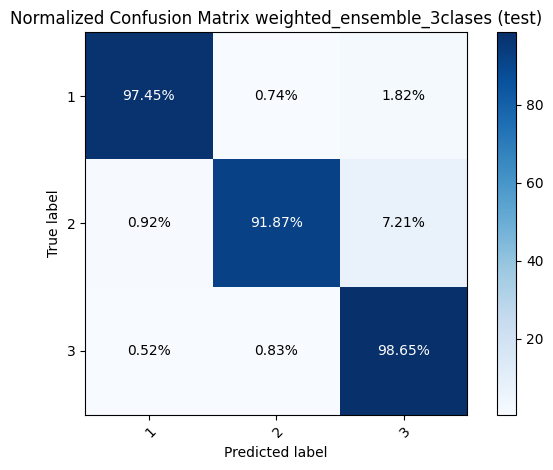

'Y Test'

(array([0, 1, 2], dtype=int64), array([1763,  763, 3627], dtype=int64))

'Y Test Predictions'

(array([0, 1, 2], dtype=int64), array([1744,  744, 3665], dtype=int64))

Score for weighted_ensemble_3clases
          Clase  precision    recall  f1-score  support  accuracy  \
0             0   0.985092  0.974475  0.979755   1763.0       NaN   
1             1   0.942204  0.918742  0.930325    763.0       NaN   
2             2   0.976262  0.986490  0.981349   3627.0       NaN   
3      accuracy        NaN       NaN       NaN      NaN  0.974647   
4     macro avg   0.967853  0.959902  0.963810   6153.0       NaN   
5  weighted avg   0.974569  0.974647  0.974565   6153.0       NaN   

                      Modelo  
0  weighted_votingclassifier  
1  weighted_votingclassifier  
2  weighted_votingclassifier  
3  weighted_votingclassifier  
4  weighted_votingclassifier  
5  weighted_votingclassifier  


In [24]:
model_config = "svc_linear"
optuna_db = create_db(model_config, 3)
svc_linear_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "svc_rbf"
optuna_db = create_db(model_config, 3)
svc_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)

model_config = "catboost"
optuna_db = create_db(model_config, 3)
catboost_32 = pipeline_config(model_config, pipeline_steps[model_config], optuna_db)
catboost_32 = CatBoostWrapper(catboost_32)

classifiers = [('SVC', svc_32),
               ('SVC Linear', svc_linear_32),
               ('Catboost', catboost_32)
              ]

# Clasificador personalizado
voting_clf = WeightedVotingClassifier(
    estimators=classifiers,
    class_weights={
        0: [0.6, 0.2, 0.2],  # Pesos para clase 0
        1: [0.2, 0.6, 0.2],  # Pesos para clase 1
        2: [0.3, 0.2, 0.5],  # Pesos para clase 2
    }
)

# Entrenamiento
voting_clf.fit(X, y)

# Predicción
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

cm_test_ensemble_test, report_test_ensemble_test = test_scoring("weighted_votingclassifier", models[6], y_train, y_train_pred, y_test, y_test_pred)